## Project Background
Autism Spectrum Disorder (ASD) affects communication and behavior. Early identification and intervention can significantly improve outcomes. This project aims to identify individuals who may be at higher risk for ASD based on commonly collected screening data (e.g., questionnaire responses, basic demographic information).

## Objective
The goal is to create a ML Ops tool that can do early detection for potential cases towards further clinical assessment, potentially speeding up the screening process and directing resources more effectively. This tool will predict the likelihood of an individual having Autism Spectrum Disorder (ASD) based on screening questionnaire data and demographic features, aiming for high sensitivity (recall) to minimize missed cases. This is a supervised binary classification problem (ASD vs. No ASD).

## Technical Background:
The model will use data from screenings to learn patterns in these features to distinguish between individuals diagnosed with ASD and those without.Technical challenges may involve preprocessing potentially imbalanced data, and ensuring fairness across different demographic groups by analyzing key metrics.
Evaluation will focus on classification performance metrics relevant to screening:
Primary Metrics: Recall (Sensitivity), AUC, PRC, Accuracy, Precision, F1-Score

Secondary Metrics: DIR, Relative Error, Force Plots. Correlation Plots.

Business/Clinical Relevance: Quantify the model's potential impact by simulating its use on a test set: calculate the percentage of true positive cases identified within the top X% of model predictions (e.g., top 20%), representing potential to accelerate workload for clinicians focusing on these high-risk individuals.


### Import libraries

In [38]:
import numpy as np 
import pandas as pd 
import boto3
import sagemaker
from pyathena import connect
import matplotlib.pyplot as plt
import seaborn as sns

### Load test and train dataset

In [39]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [40]:
train_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [41]:
test_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
0,1,1,1,0,0,1,1,0,0,1,...,15.599481,m,White-European,yes,no,India,no,12.399055,18 and more,Self
1,2,1,0,0,0,0,0,0,1,0,...,27.181099,m,Asian,no,no,Mexico,no,6.551598,18 and more,Self
2,3,1,1,1,0,1,1,0,1,1,...,31.643906,m,White-European,yes,no,Egypt,no,3.180663,18 and more,Self
3,4,0,0,0,0,0,0,0,0,0,...,25.369210,m,?,no,no,India,no,2.220766,18 and more,Self
4,5,0,0,0,1,0,0,0,0,0,...,9.078580,m,?,no,no,Italy,no,7.252028,18 and more,Self


### Create AWS session

In [42]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [43]:
### Create and Push Data to S3 bucket

In [44]:
s3_private_path_tsv = "s3://{}/autism_prediction/tsv".format(bucket)
print(s3_private_path_tsv)

s3://sagemaker-us-east-1-553246940090/autism_prediction/tsv


In [45]:
!aws s3 cp "./test.csv" $s3_private_path_tsv/
!aws s3 cp "./train.csv" $s3_private_path_tsv/

upload: ./test.csv to s3://sagemaker-us-east-1-553246940090/autism_prediction/tsv/test.csv
upload: ./train.csv to s3://sagemaker-us-east-1-553246940090/autism_prediction/tsv/train.csv


### Create ASW S3 Athena Database

In [46]:
database_name = "dso_asd_v1"
s3_staging_dir = "s3://sagemaker-us-east-1-672518276407/autism_prediction/tsv"
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS dso_asd_v1


/tmp/ipykernel_32413/873326040.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [47]:
statement = "SHOW DATABASES LIKE 'dso_asd_v1'"

df_show = pd.read_sql(statement, conn)
df_show.head(10)

/tmp/ipykernel_32413/2483888340.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,dso_asd_v1


In [48]:
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [49]:
import awswrangler as wr

# Database name
database_name = "dso_asd_v1_parquet"

# Create the Glue database if it doesn't exist
try:
    wr.catalog.create_database(name=database_name)
    print(f"Database '{database_name}' created successfully or already exists.")
except Exception as e:
    print(f"Error creating database: {e}")

Error creating database: Database dso_asd_v1_parquet already exists and <exist_ok> is set to False.


In [50]:
# S3 bucket and file path for Parquet
bucket_name = "sagemaker-us-east-1-672518276407"
parquet_path = f"s3://{bucket_name}/autism_prediction/parquet/asd_dataset.parquet" 

# Save DataFrame as Parquet to S3
try:
    wr.s3.to_parquet(
        df=train_df,
        path=parquet_path,
        dataset=True,
        mode="overwrite",
        database=database_name,
        table="asd_parquet"
    )
    print(f"Data uploaded successfully to {parquet_path} as Parquet.")
except Exception as e:
    print(f"Error uploading DataFrame to S3: {e}")

Data uploaded successfully to s3://sagemaker-us-east-1-672518276407/autism_prediction/parquet/asd_dataset.parquet as Parquet.


In [51]:
# List all tables in the specified database
try:
    tables = list(wr.catalog.get_tables(database=database_name))
    print("Tables in the database:")
    for table in tables:
        print(f"- {table['Name']}")
except Exception as e:
    print(f"Error retrieving tables: {e}")

Tables in the database:
- asd_parquet


### Query the data from AWS Athena DB

In [52]:
# Query the table to check if the data is loaded
try:
    query = f"SELECT * FROM {database_name}.asd_parquet LIMIT 5"
    df_sample = wr.athena.read_sql_query(query, database=database_name)
    print("Data from the ASD Athena table:")
    print(df_sample)
except Exception as e:
    print(f"Error querying table: {e}")

Data from the ASD Athena table:
   id  a1_score  a2_score  a3_score  a4_score  a5_score  a6_score  a7_score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   a8_score  a9_score  ...  gender       ethnicity jaundice austim  \
0         0         1  ...       f               ?       no     no   
1         0         0  ...       m               ?       no     no   
2         1         1  ...       m  White-European       no    yes   
3         0         0  ...       f               ?       no     no   
4         0         0  ...       m               ?       no     no   

   contry_of_res used_app_before     result     age_desc  relation class

### Plotting diagrams

<Axes: xlabel='Class/ASD', ylabel='age'>

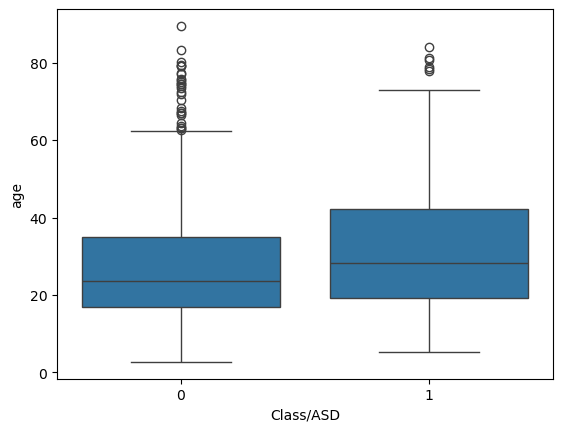

In [53]:
sns.boxplot(x = train_df['Class/ASD'], y = train_df['age'])

<Axes: xlabel='age', ylabel='Count'>

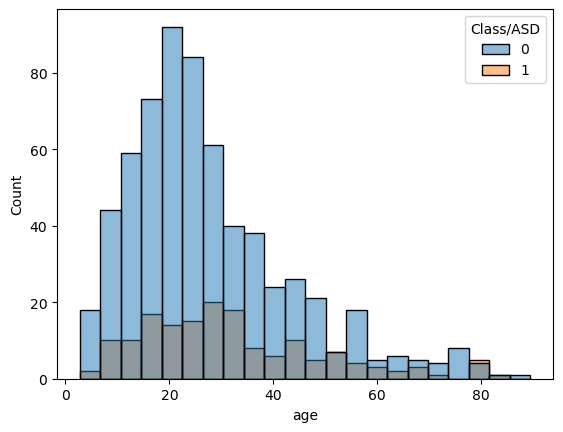

In [54]:
sns.histplot(x = train_df['age'], hue = train_df['Class/ASD'])

<Axes: xlabel='Class/ASD', ylabel='result'>

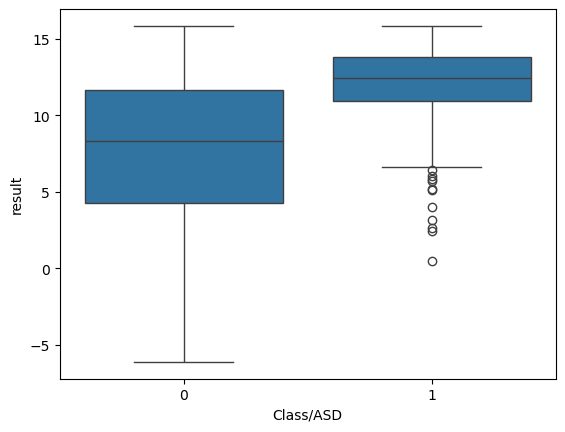

In [55]:
sns.boxplot(x = train_df['Class/ASD'], y = train_df['result'])

In [56]:
def get_num_cat_cols(df):
    num_cls = [x for x in df.columns if df[x].dtype != 'object']
    cat_cls = [x for x in df.columns if x not in num_cls]

    print(f'Numerical columns \n',num_cls)
    print(f'Categorical columns \n',cat_cls)
    
    return num_cls, cat_cls
num_cols, cat_cols = get_num_cat_cols(train_df)

Numerical columns 
 ['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result', 'Class/ASD']
Categorical columns 
 ['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'age_desc', 'relation']


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def cat_col_test(df, cat_colname, target_colname):
    print(f"Column name : {cat_colname}")

    # Contingency table
    ct = pd.crosstab(df[cat_colname], df[target_colname])
    print("\nContingency Table:\n", ct)

    # Chi-square test
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"\nChi-square Statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected Frequencies:\n{expected}")

    # Interpretation
    alpha = 0.05
    if p < alpha:
        print(f"Significant relationship (p={p:.4f}) between '{cat_colname}' and '{target_colname}'")
    else:
        print(f"No significant relationship (p={p:.4f}) between '{cat_colname}' and '{target_colname}'")

    # Plot
    ax = ct.plot(kind='bar', stacked=True, rot=45)
    ax.legend(title=target_colname, bbox_to_anchor=(1, 1.02), loc='upper left')

    for c in ax.containers:
        ax.bar_label(c, label_type='center', fontsize=8)
    plt.tight_layout()
    plt.show()


Column name : gender

Contingency Table:
 Class/ASD    0    1
gender             
f          215   55
m          424  106

Chi-square Statistic: 0.0009
P-value: 0.9758
Degrees of Freedom: 1
Expected Frequencies:
[[215.6625  54.3375]
 [423.3375 106.6625]]
No significant relationship (p=0.9758) between 'gender' and 'Class/ASD'


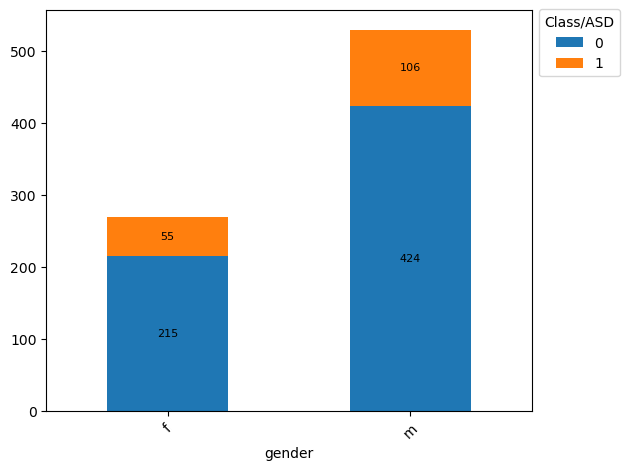

Column name : ethnicity

Contingency Table:
 Class/ASD          0    1
ethnicity                
?                196    7
Asian             63    4
Black             41    6
Hispanic           7    2
Latino            13    4
Middle Eastern    91    6
Others            27    2
Pasifika          26    6
South Asian       31    3
Turkish            5    0
White-European   136  121
others             3    0

Chi-square Statistic: 181.0167
P-value: 0.0000
Degrees of Freedom: 11
Expected Frequencies:
[[162.14625  40.85375]
 [ 53.51625  13.48375]
 [ 37.54125   9.45875]
 [  7.18875   1.81125]
 [ 13.57875   3.42125]
 [ 77.47875  19.52125]
 [ 23.16375   5.83625]
 [ 25.56      6.44   ]
 [ 27.1575    6.8425 ]
 [  3.99375   1.00625]
 [205.27875  51.72125]
 [  2.39625   0.60375]]
Significant relationship (p=0.0000) between 'ethnicity' and 'Class/ASD'


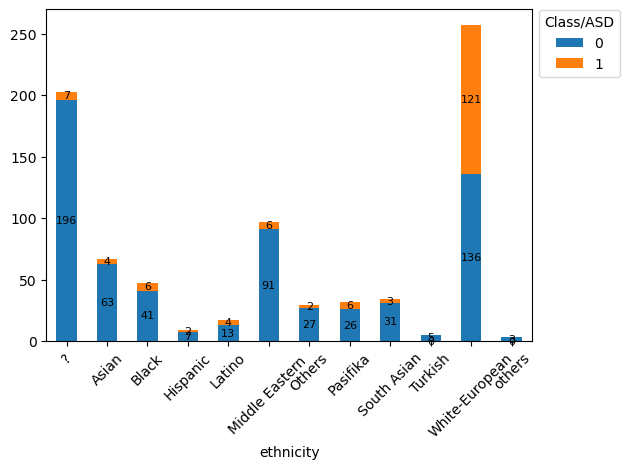

Column name : jaundice

Contingency Table:
 Class/ASD    0    1
jaundice           
no         510  105
yes        129   56

Chi-square Statistic: 14.5987
P-value: 0.0001
Degrees of Freedom: 1
Expected Frequencies:
[[491.23125 123.76875]
 [147.76875  37.23125]]
Significant relationship (p=0.0001) between 'jaundice' and 'Class/ASD'


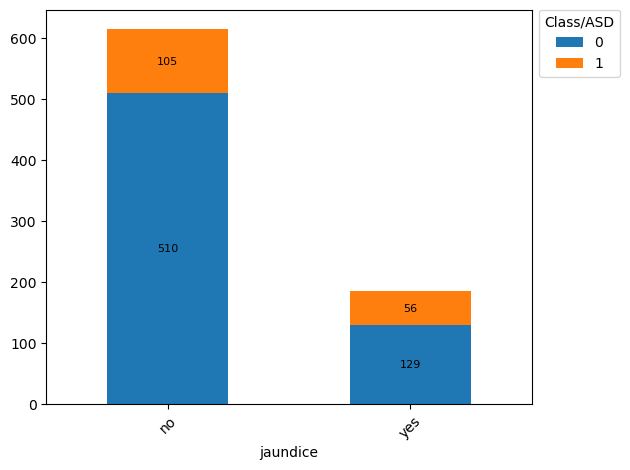

Column name : austim

Contingency Table:
 Class/ASD    0   1
austim            
no         577  92
yes         62  69

Chi-square Statistic: 100.8225
P-value: 0.0000
Degrees of Freedom: 1
Expected Frequencies:
[[534.36375 134.63625]
 [104.63625  26.36375]]
Significant relationship (p=0.0000) between 'austim' and 'Class/ASD'


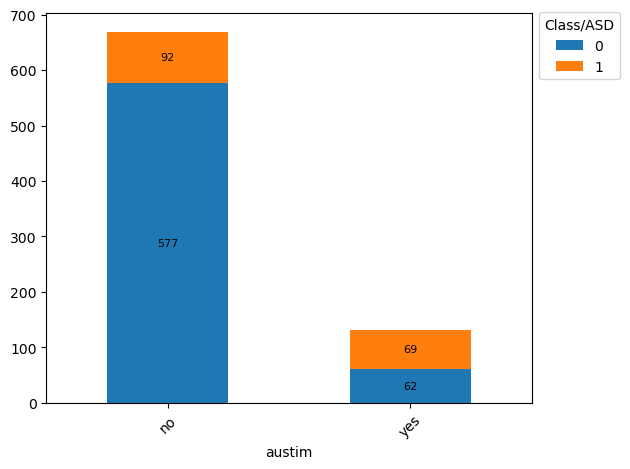

Column name : contry_of_res

Contingency Table:
 Class/ASD               0   1
contry_of_res                
Afghanistan            19   3
AmericanSamoa           4   0
Angola                  1   0
Argentina               1   0
Armenia                 2   2
Aruba                   2   2
Australia              30   7
Austria                17   1
Azerbaijan              2   2
Bahamas                 5   1
Bangladesh              1   0
Belgium                 1   0
Bolivia                 2   1
Brazil                 11   1
Burundi                 0   1
Canada                 21   9
China                   4   0
Cyprus                  1   1
Czech Republic          1   0
Egypt                   1   0
Ethiopia                2   1
France                  7   3
Germany                 3   0
Hong Kong               1   0
Iceland                 3   0
India                 105   3
Iran                    7   1
Iraq                    4   0
Ireland                 7   2
Italy                

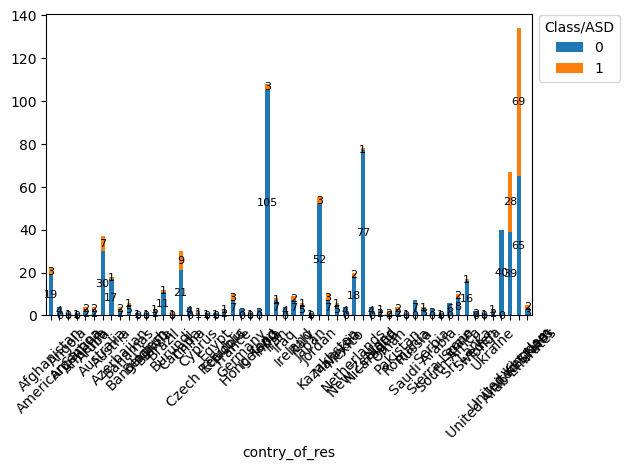

Column name : used_app_before

Contingency Table:
 Class/ASD          0    1
used_app_before          
no               602  148
yes               37   13

Chi-square Statistic: 0.7885
P-value: 0.3746
Degrees of Freedom: 1
Expected Frequencies:
[[599.0625 150.9375]
 [ 39.9375  10.0625]]
No significant relationship (p=0.3746) between 'used_app_before' and 'Class/ASD'


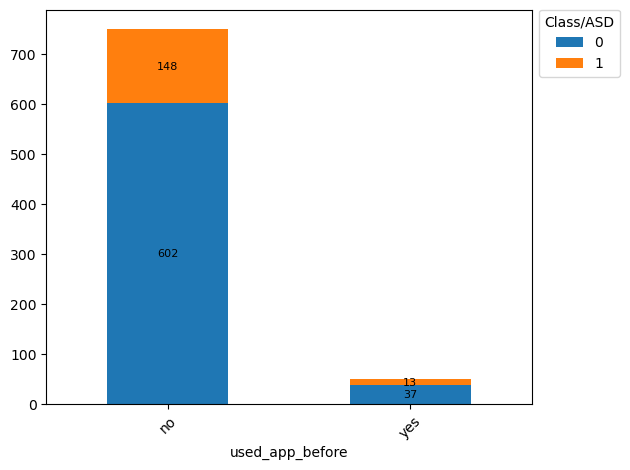

Column name : age_desc

Contingency Table:
 Class/ASD      0    1
age_desc             
18 and more  639  161

Chi-square Statistic: 0.0000
P-value: 1.0000
Degrees of Freedom: 0
Expected Frequencies:
[[639. 161.]]
No significant relationship (p=1.0000) between 'age_desc' and 'Class/ASD'


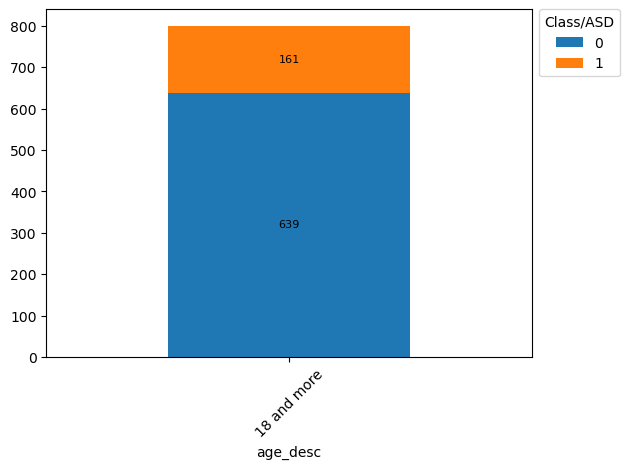

Column name : relation

Contingency Table:
 Class/ASD                   0    1
relation                          
?                          39    1
Health care professional    1    1
Others                      2    0
Parent                     21    8
Relative                   14    4
Self                      562  147

Chi-square Statistic: 10.5611
P-value: 0.0608
Degrees of Freedom: 5
Expected Frequencies:
[[3.1950000e+01 8.0500000e+00]
 [1.5975000e+00 4.0250000e-01]
 [1.5975000e+00 4.0250000e-01]
 [2.3163750e+01 5.8362500e+00]
 [1.4377500e+01 3.6225000e+00]
 [5.6631375e+02 1.4268625e+02]]
No significant relationship (p=0.0608) between 'relation' and 'Class/ASD'


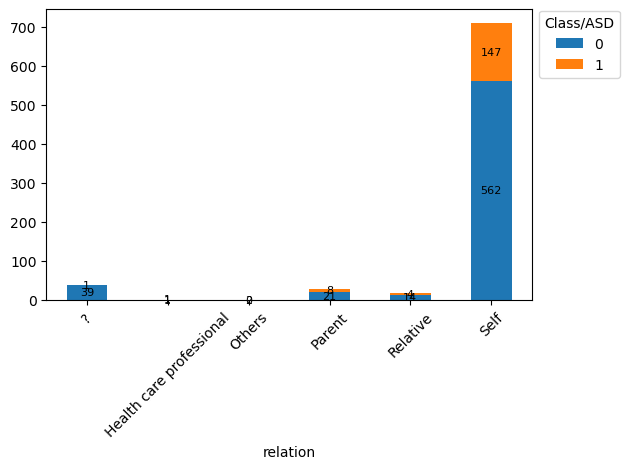

In [58]:
for col in cat_cols:
    cat_col_test(train_df, col, 'Class/ASD')

## Create the feature group

In [59]:
import boto3
import pandas as pd
import time
import uuid
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role

# --- Configuration ---
s3_parquet_uri = "s3://sagemaker-us-east-1-672518276407/autism_prediction/parquet/asd_dataset.parquet"
bucket_prefix = "autism-feature-store"
record_identifier_feature_name = "record_id"
event_time_feature_name = "event_time"
feature_group_name = f"asd-feature-group-{uuid.uuid4().hex[:8]}"

# --- Initialize Session and Clients ---
region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client("sagemaker")
featurestore_runtime = boto_session.client("sagemaker-featurestore-runtime")

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

default_s3_bucket = feature_store_session.default_bucket()

# --- Load Parquet from S3 ---
df = pd.read_parquet(s3_parquet_uri)
print(f"Loaded Parquet file from {s3_parquet_uri} with shape: {df.shape}")

# --- Prepare Data ---
df.columns = [c.strip().replace(" ", "_").replace("<", "less_than_") for c in df.columns]

# Add required columns
if record_identifier_feature_name not in df.columns:
    df.insert(0, record_identifier_feature_name, range(1, 1 + len(df)))

if event_time_feature_name not in df.columns:
    df[event_time_feature_name] = pd.Timestamp.now().strftime("%Y-%m-%dT%H:%M:%SZ")

# --- Create Feature Group ---
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)
feature_group.load_feature_definitions(data_frame=df)

role_arn = get_execution_role()

feature_group.create(
    s3_uri=f"s3://{default_s3_bucket}/{bucket_prefix}/offline_store",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role_arn,
    enable_online_store=True
)

# --- Wait for Feature Group to be Active ---
def wait_for_feature_group_creation_complete(fg):
    status = fg.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group creation...")
        time.sleep(5)
        status = fg.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Feature Group creation failed: {status}")
    print(f"Feature Group '{fg.name}' created successfully.")

wait_for_feature_group_creation_complete(feature_group)

# --- Ingest Records into Feature Store ---
records = df.to_dict(orient="records")

for record in records:
    featurestore_runtime.put_record(
        FeatureGroupName=feature_group_name,
        Record=[{"FeatureName": k, "ValueAsString": str(v)} for k, v in record.items()]
    )

print(f" Data ingestion completed for Feature Group: {feature_group_name}")


Loaded Parquet file from s3://sagemaker-us-east-1-672518276407/autism_prediction/parquet/asd_dataset.parquet with shape: (800, 22)
Waiting for Feature Group creation...
Waiting for Feature Group creation...
Waiting for Feature Group creation...
Waiting for Feature Group creation...
Feature Group 'asd-feature-group-27f177ba' created successfully.
 Data ingestion completed for Feature Group: asd-feature-group-27f177ba


### Query online values from feature group

In [60]:
import boto3

# --- Configuration ---
feature_group_name = "asd-feature-group-55aa5b50"  
# Assuming this line already exists:
records = df.to_dict(orient="records")

# Extract all record_id values
record_ids = [record["record_id"] for record in records]


# --- Initialize Feature Store Runtime Client ---
region = boto3.Session().region_name
featurestore_runtime = boto3.client("sagemaker-featurestore-runtime", region_name=region)

# --- Query from Online Store ---
response = featurestore_runtime.get_record(
    FeatureGroupName=feature_group_name,
    RecordIdentifierValueAsString=str(record_ids[0])
)

# --- Process and Print Results ---
if "Record" in response:
    record_values = {item['FeatureName']: item['ValueAsString'] for item in response['Record']}
    print("Record fetched from Online Store:")
    for key, value in record_values.items():
        print(f"{key}: {value}")
else:
    print("Record not found in Online Store.")


Record fetched from Online Store:
record_id: 1
id: 1
a1_score: 1
a2_score: 0
a3_score: 1
a4_score: 0
a5_score: 1
a6_score: 0
a7_score: 1
a8_score: 0
a9_score: 1
a10_score: 1
age: 38.17274623
gender: f
ethnicity: ?
jaundice: no
austim: no
contry_of_res: Austria
used_app_before: no
result: 6.351165589
age_desc: 18 and more
relation: Self
class_asd: 0
event_time: 2025-06-19T19:42:10Z


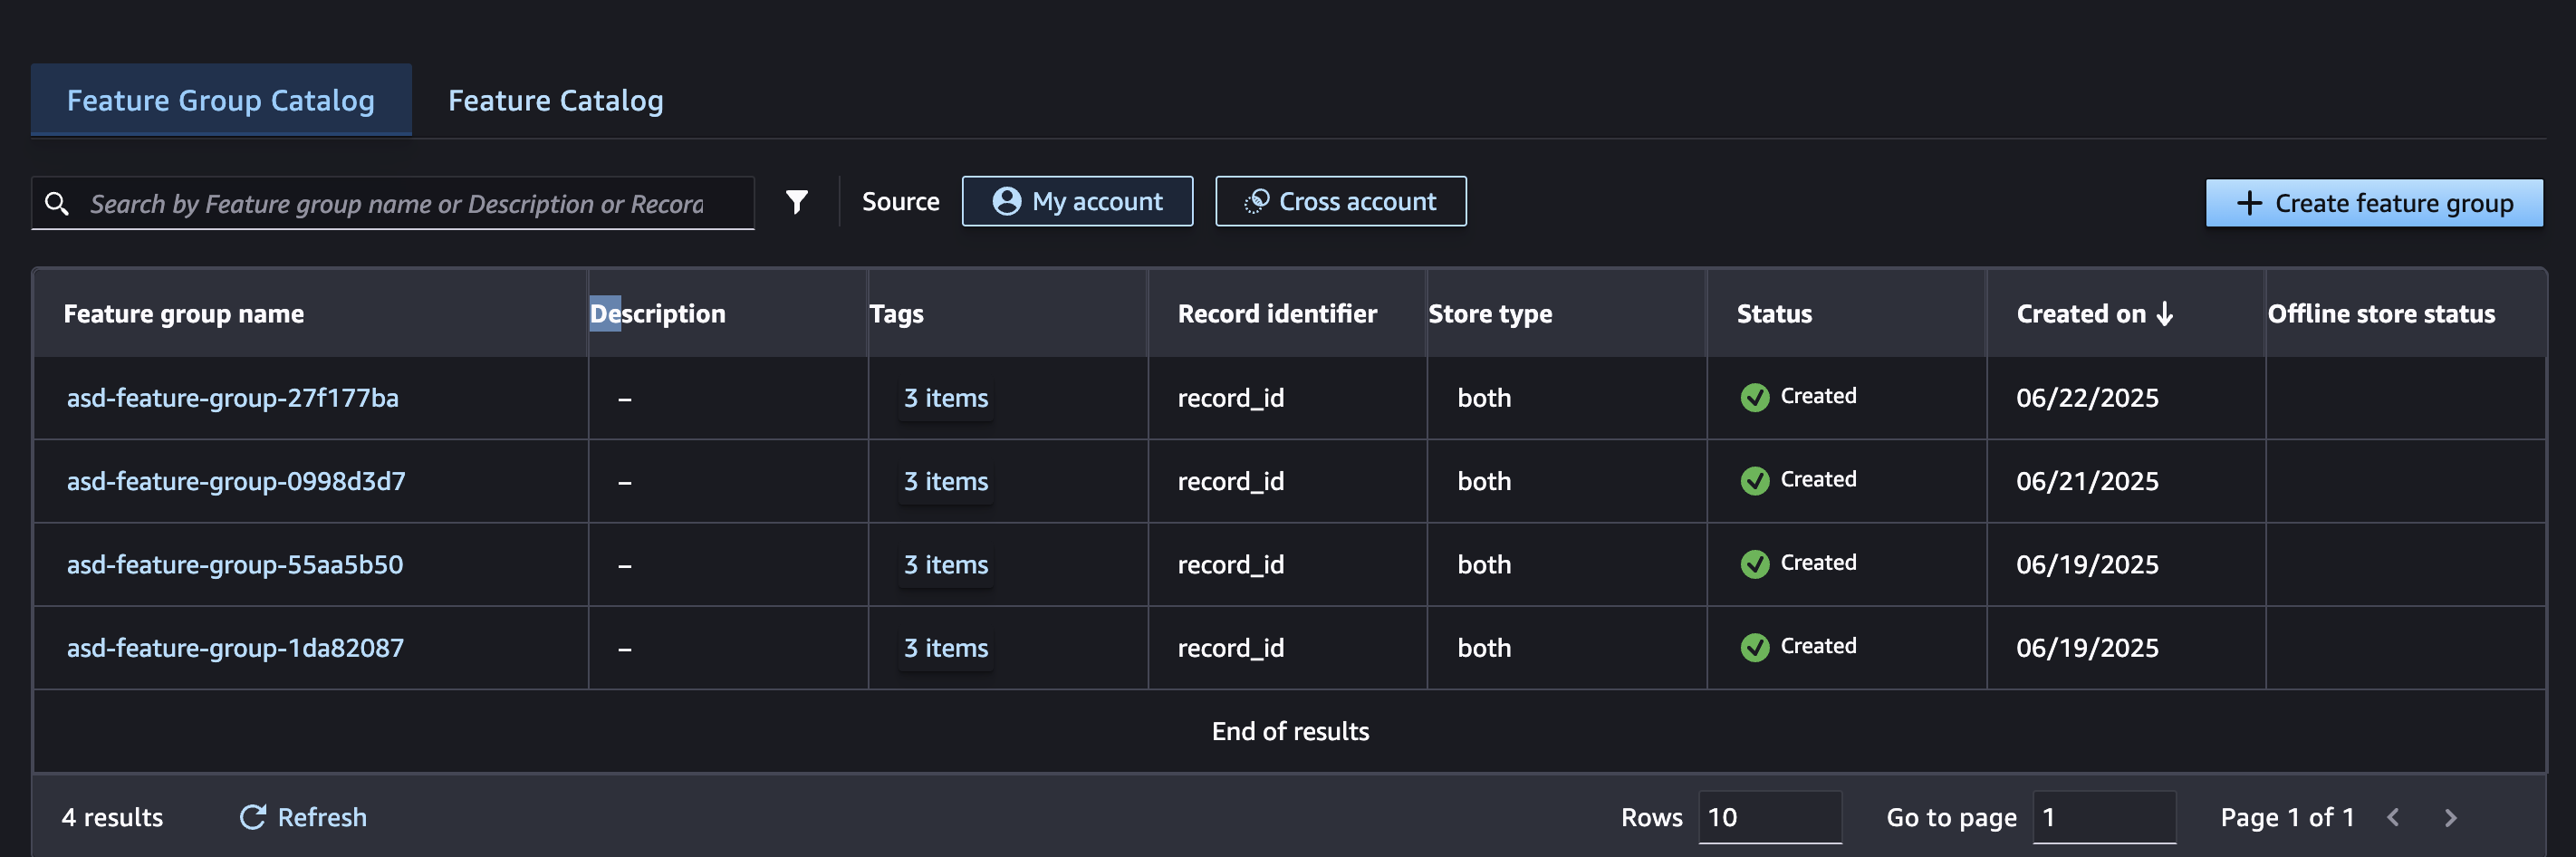

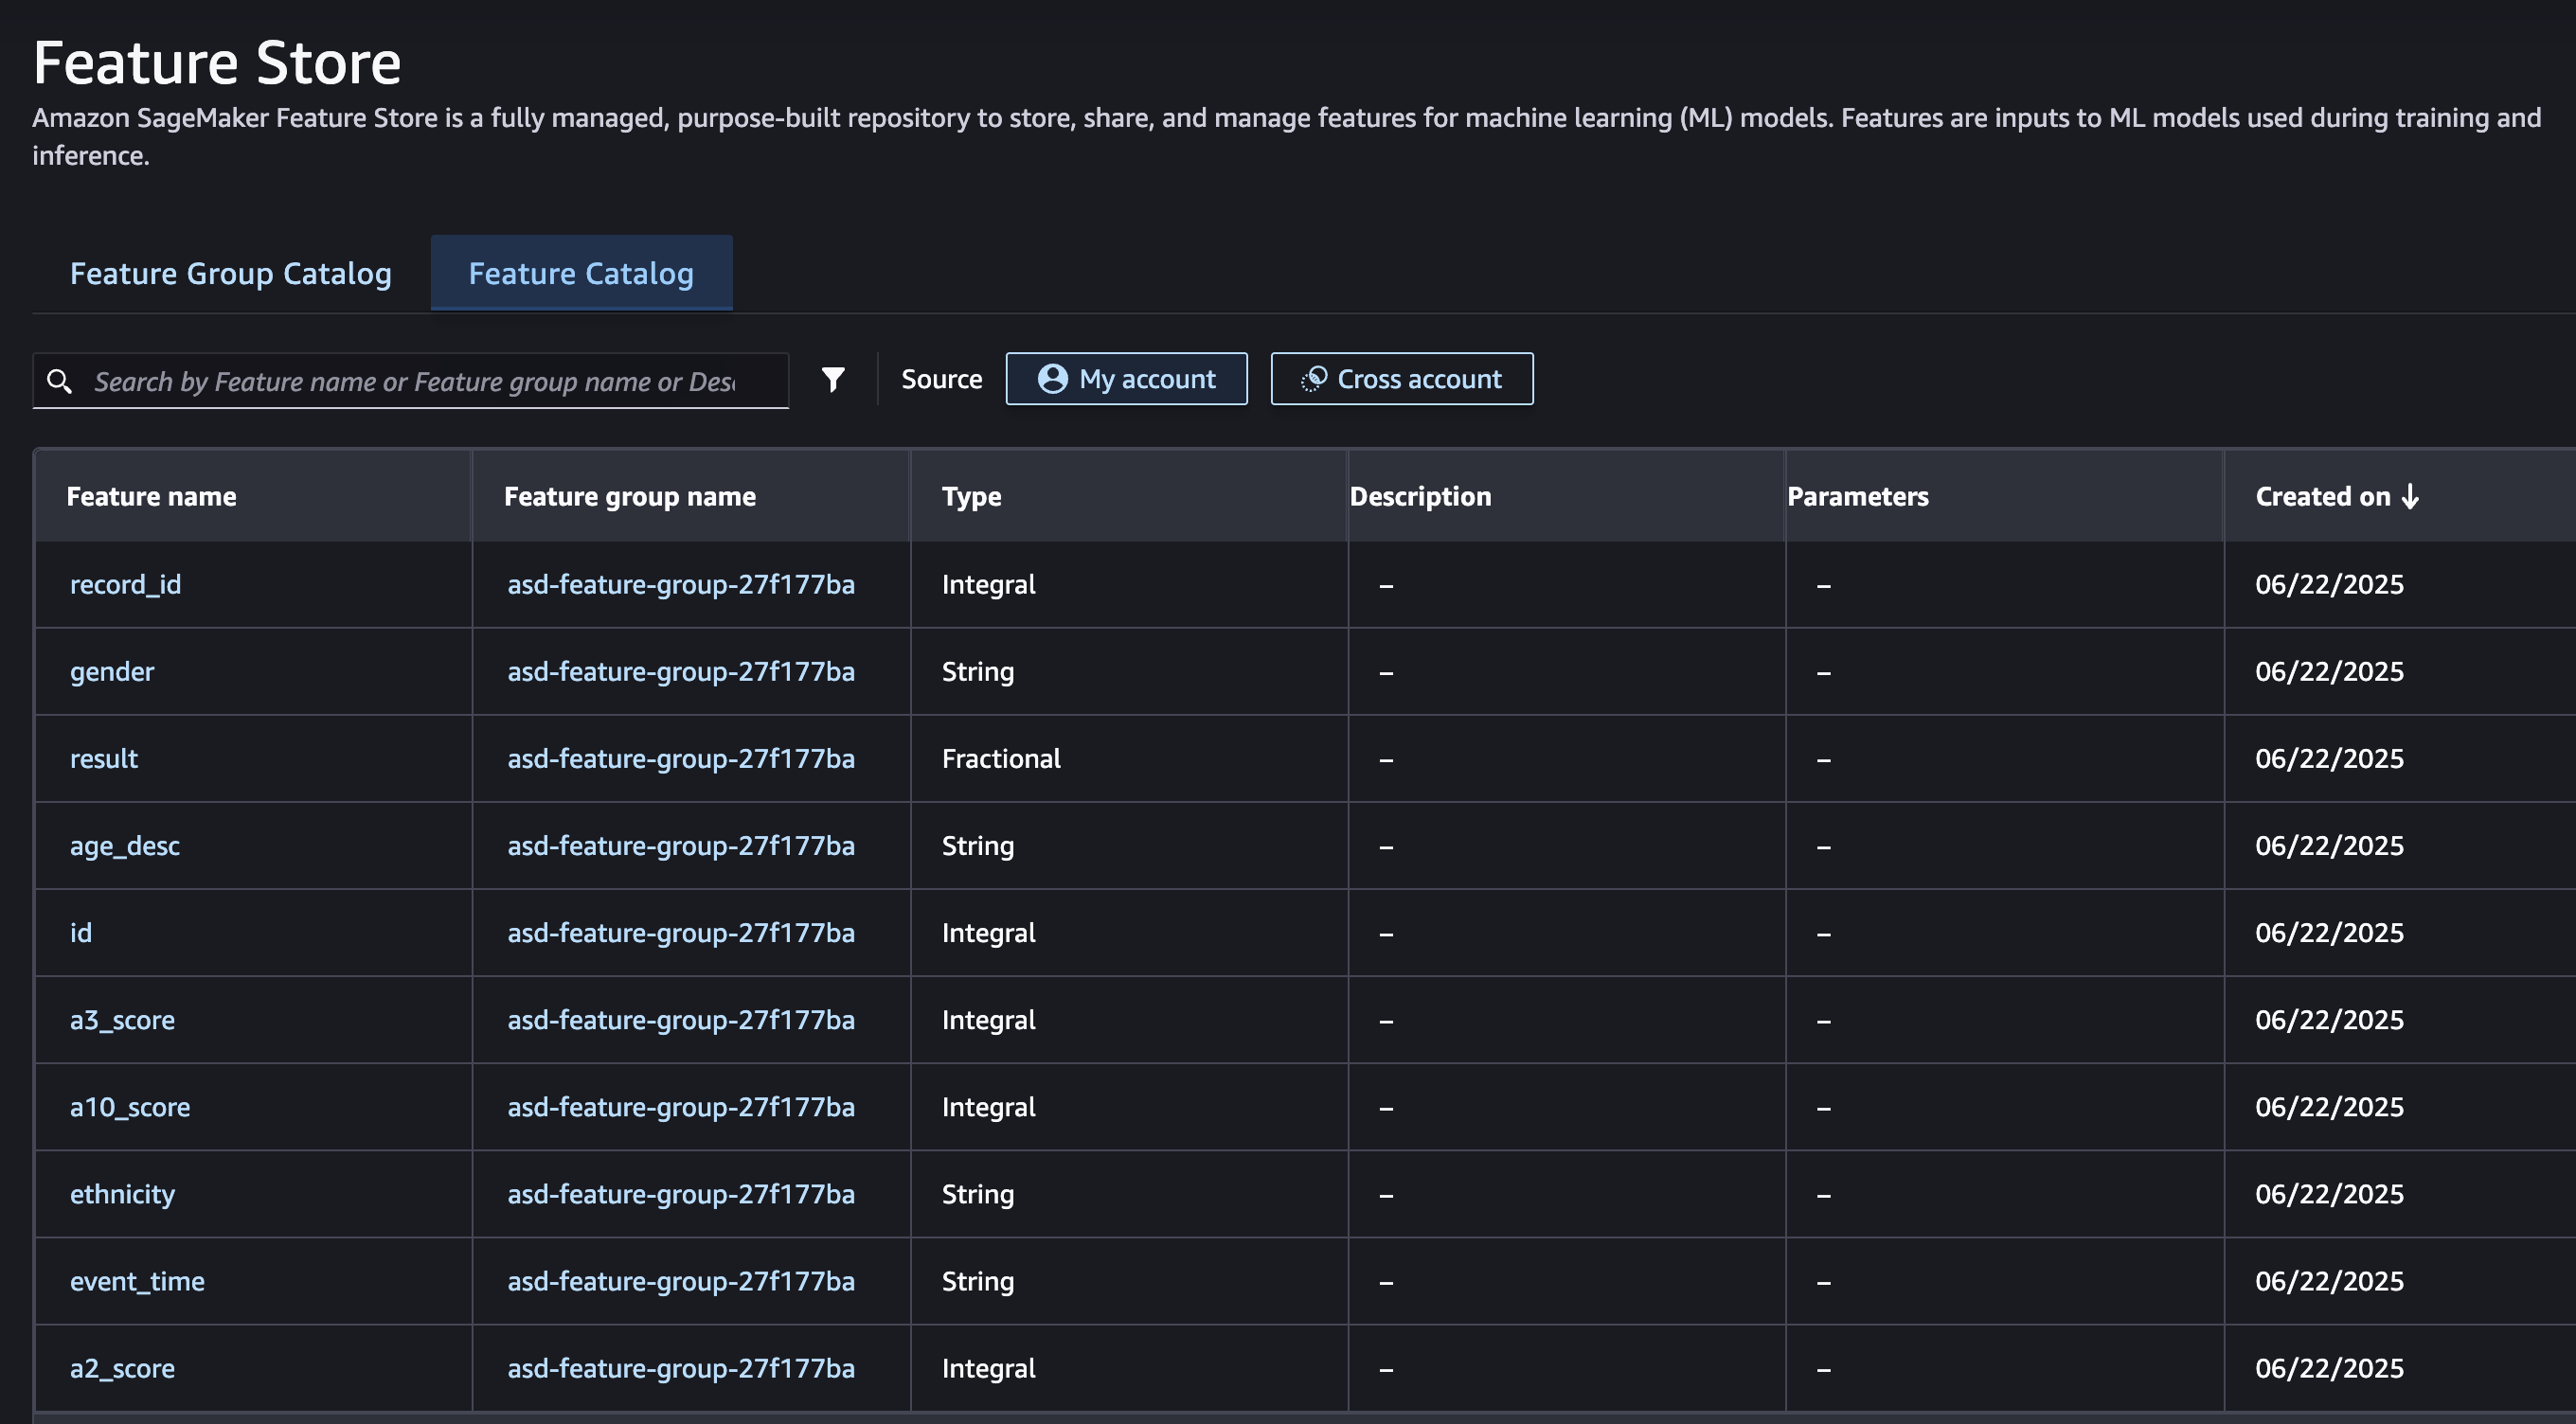

## Build and train dataset from Online store using XGBoost Model

In [64]:
# Check unique values in the label column before training
label_values = train_df["Class/ASD"].unique()
label_dtype = train_df["Class/ASD"].dtype

label_values, label_dtype

(array([0, 1]), dtype('int64'))

In [66]:
# --- Load & Preprocess ---
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load original CSVs
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Drop irrelevant or non-numeric columns
drop_columns = ["ID", "age_desc", "relation"]
train_df_clean = train_df.drop(columns=drop_columns)
test_df_clean = test_df.drop(columns=drop_columns, errors='ignore')

# Encode categorical columns using combined values
for col in train_df_clean.select_dtypes(include='object').columns:
    le = LabelEncoder()
    combined = pd.concat([train_df_clean[col], test_df_clean[col]], axis=0).astype(str)
    le.fit(combined)
    train_df_clean[col] = le.transform(train_df_clean[col].astype(str))
    test_df_clean[col] = le.transform(test_df_clean[col].astype(str))

# Move label to front
target = "Class/ASD"
train_df_final = train_df_clean[[target] + [c for c in train_df_clean.columns if c != target]]
test_df_final = test_df_clean[[c for c in train_df_final.columns if c != target]]  # test has no label

# Remove any NaNs (just in case)
train_df_final.dropna(inplace=True)
test_df_final.dropna(inplace=True)

# Save processed versions
train_df_final.to_csv("train_xgb_clean.csv", index=False, header=False)
test_df_final.to_csv("test_xgb_clean.csv", index=False, header=False)


In [67]:
### Print the clean dataset for confirmation
train_df_clean.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.172746,0,0,0,0,7,0,6.351166,0
1,0,0,0,0,0,0,0,0,0,0,47.750517,1,0,0,0,25,0,2.255185,0
2,1,1,1,1,1,1,1,1,1,1,7.380373,1,10,0,1,56,0,14.851484,1
3,0,0,0,0,0,0,0,0,0,0,23.561927,0,0,0,0,56,0,2.276617,0
4,0,0,0,0,0,0,0,0,0,0,43.205790,1,0,0,0,48,0,-4.777286,0


In [68]:
import boto3
import sagemaker
from sagemaker import image_uris, estimator, inputs
from time import gmtime, strftime
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# --- Step 1: Setup ---
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.Session().region_name

prefix = "autism_prediction/csv"
job_name = "xgb-binary-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = f"s3://{bucket}/{prefix}/output/{job_name}"

# --- Step 2: Upload cleaned CSVs to S3 ---
train_local = "train_xgb_clean.csv"
test_local = "test_xgb_clean.csv"

train_s3_path = sess.upload_data(train_local, bucket=bucket, key_prefix=f"{prefix}/train")
test_s3_path = sess.upload_data(test_local, bucket=bucket, key_prefix=f"{prefix}/validation")

print("Uploaded:")
print("Train:", train_s3_path)
print("Validation:", test_s3_path)

# --- Step 3: Configure XGBoost Estimator ---
xgb_image = image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.7-1"
)

xgb = estimator.Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=50,
    output_path=output_location,
    sagemaker_session=sess
)

xgb.set_hyperparameters(
    objective="binary:logistic",
    num_round=100,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=1
)

# --- Step 4: Train the Model ---
train_input = inputs.TrainingInput(train_s3_path, content_type="text/csv")
validation_input = inputs.TrainingInput(test_s3_path, content_type="text/csv")

xgb.fit(inputs={"train": train_input, "validation": validation_input}, job_name=job_name)

# --- Step 5: Predict Locally for Accuracy ---
# Load test set and extract true labels and features
df_val = pd.read_csv(test_local, header=None)
y_true = df_val.iloc[:, 0].values
X_val = df_val.iloc[:, 1:].values

# Download the model artifact
model_artifact_path = xgb.model_data
print(" Model artifact location:", model_artifact_path)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: xgb-binary-2025-06-22-18-54-51


Uploaded:
Train: s3://sagemaker-us-east-1-553246940090/autism_prediction/csv/train/train_xgb_clean.csv
Validation: s3://sagemaker-us-east-1-553246940090/autism_prediction/csv/validation/test_xgb_clean.csv
2025-06-22 18:54:53 Starting - Starting the training job...
2025-06-22 18:55:09 Starting - Preparing the instances for training...
2025-06-22 18:55:31 Downloading - Downloading input data...
2025-06-22 18:56:16 Downloading - Downloading the training image......
2025-06-22 18:57:22 Training - Training image download completed. Training in progress.
2025-06-22 18:57:22 Uploading - Uploading generated training model[2025-06-22 18:57:18.871 ip-10-0-109-127.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-06-22 18:57:18.907 ip-10-0-109-127.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-06-22:18:57:19:INFO] Imported framework sagemaker_xgboost_container.training
[2025-06-22:18:57:19:INFO] Failed to parse hyperparameter objectiv

### Generate the model accuracy matrix

In [70]:
import boto3
import os
import tarfile
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# --- Step 1: Load validation data ---
df_val = pd.read_csv("test_xgb_clean.csv", header=None)
y_true = df_val.iloc[:, 0].values
X_val = df_val.iloc[:, 1:].values

# --- Step 2: Define S3 model path ---
s3_uri = "s3://sagemaker-us-east-1-553246940090/autism_prediction/csv/output/xgb-binary-2025-06-22-18-54-51/xgb-binary-2025-06-22-18-54-51/output/model.tar.gz"
bucket = "sagemaker-us-east-1-553246940090"
key = "autism_prediction/csv/output/xgb-binary-2025-06-22-18-54-51/xgb-binary-2025-06-22-18-54-51/output/model.tar.gz"

# --- Step 3: Download model.tar.gz using boto3 ---
s3 = boto3.client("s3")
local_model_path = "/tmp/model.tar.gz"
s3.download_file(bucket, key, local_model_path)

# --- Step 4: Extract model file ---
extract_dir = "/tmp/xgb_model"
os.makedirs(extract_dir, exist_ok=True)

with tarfile.open(local_model_path) as tar:
    tar.extractall(path=extract_dir)

# --- Step 5: Load model and predict ---
booster = xgb.Booster()
booster.load_model(os.path.join(extract_dir, "xgboost-model"))

dmatrix = xgb.DMatrix(X_val)
y_pred_probs = booster.predict(dmatrix)
y_pred = (y_pred_probs > 0.5).astype(int)

# --- Step 6: Evaluate Accuracy ---
accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.4250


/tmp/ipykernel_32413/2195076799.py:29: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


The validation accuracy is low, we need to improve the model accuracy a bit
### Fine-tuning the data model using hyper-parameter tuning

In [73]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Reload clean data
df = pd.read_csv("train_xgb_clean.csv", header=None)
y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Recombine and save
df_resampled = pd.DataFrame(np.column_stack((y_res, X_res)))
df_resampled.to_csv("train_xgb_balanced.csv", index=False, header=False)


In [74]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import image_uris, estimator, inputs
from time import gmtime, strftime
import sagemaker
import boto3

# --- Setup ---
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket = sess.default_bucket()
prefix = "autism_prediction/csv"
job_name = "xgb-tuner-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = f"s3://{bucket}/{prefix}/output/{job_name}"

# --- Upload SMOTE-balanced training dataset ---
balanced_train_path = "train_xgb_balanced.csv"
train_upload_path = sess.upload_data(balanced_train_path, bucket=bucket, key_prefix=f"{prefix}/train")
test_upload_path = sess.upload_data("test_xgb_clean.csv", bucket=bucket, key_prefix=f"{prefix}/validation")

# --- XGBoost image URI ---
xgb_image = image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.7-1"
)

# --- Define XGBoost Estimator ---
xgb = estimator.Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=50,
    output_path=output_location,
    sagemaker_session=sess
)

xgb.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",  # More robust for class imbalance
    num_round=100
)

# --- Define hyperparameter search space ---
hyperparameter_ranges = {
    "eta": ContinuousParameter(0.1, 0.5),
    "min_child_weight": IntegerParameter(1, 10),
    "subsample": ContinuousParameter(0.5, 1.0),
    "max_depth": IntegerParameter(3, 10),
    "gamma": ContinuousParameter(0, 5),
}

# --- Define Tuner ---
tuner = HyperparameterTuner(
    estimator=xgb,
    objective_metric_name="validation:auc",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=[{
        "Name": "validation:auc",
        "Regex": ".*\\[[0-9]+\\]\\tvalidation-auc:([0-9\\.]+)"
    }],
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type="Maximize"
)

# --- Define data inputs ---
train_input = inputs.TrainingInput(train_upload_path, content_type="text/csv")
validation_input = inputs.TrainingInput(test_upload_path, content_type="text/csv")

# --- Start tuning job ---
tuner.fit({"train": train_input, "validation": validation_input})

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-250622-1909


....................................................................................!


In [75]:
from sagemaker.tuner import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics("sagemaker-xgboost-250622-1909")
tuner_analytics.dataframe().sort_values("FinalObjectiveValue", ascending=False)

,eta,gamma,max_depth,min_child_weight,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
9,0.149724,2.716568,9.0,6.0,0.632947,sagemaker-xgboost-250622-1909-001-8be10e5e,Completed,0.80486,2025-06-22 19:10:32+00:00,2025-06-22 19:12:47+00:00,135.0
1,0.121157,3.957961,7.0,10.0,0.634938,sagemaker-xgboost-250622-1909-009-25a7be92,Completed,0.80338,2025-06-22 19:15:45+00:00,2025-06-22 19:16:25+00:00,40.0
6,0.236346,3.490071,9.0,10.0,0.838542,sagemaker-xgboost-250622-1909-004-a3ec79b0,Completed,0.80240,2025-06-22 19:13:02+00:00,2025-06-22 19:13:46+00:00,44.0
2,0.141157,2.725005,9.0,8.0,0.884985,sagemaker-xgboost-250622-1909-008-43ca90fd,Completed,0.80107,2025-06-22 19:15:05+00:00,2025-06-22 19:15:50+00:00,45.0
0,0.231567,3.488559,9.0,3.0,0.721595,sagemaker-xgboost-250622-1909-010-6a92cee6,Completed,0.80046,2025-06-22 19:16:06+00:00,2025-06-22 19:16:55+00:00,49.0
3,0.117357,2.201326,9.0,5.0,0.826315,sagemaker-xgboost-250622-1909-007-64f25aca,Completed,0.79821,2025-06-22 19:14:47+00:00,2025-06-22 19:15:27+00:00,40.0
7,0.106177,2.028569,3.0,4.0,0.503961,sagemaker-xgboost-250622-1909-003-d9ecfedd,Completed,0.79616,2025-06-22 19:12:53+00:00,2025-06-22 19:13:32+00:00,39.0
5,0.190220,3.442808,8.0,1.0,0.928999,sagemaker-xgboost-250622-1909-005-f5cf1703,Completed,0.79545,2025-06-22 19:13:47+00:00,2025-06-22 19:14:26+00:00,39.0
4,0.182993,0.071986,9.0,10.0,0.552048,sagemaker-xgboost-250622-1909-006-ee643406,Completed,0.79376,2025-06-22 19:14:04+00:00,2025-06-22 19:14:48+00:00,44.0
8,0.260072,3.661723,6.0,3.0,0.573362,sagemaker-xgboost-250622-1909-002-20e86a39,Completed,0.79217,2025-06-22 19:10:32+00:00,2025-06-22 19:12:37+00:00,125.0


### Get the best model artifact S3 URI

In [76]:
from sagemaker.tuner import HyperparameterTuningJobAnalytics

# Replace with your actual tuning job name
tuning_job_name = "sagemaker-xgboost-250622-1909"

# Get the best job info
tuner_analytics = HyperparameterTuningJobAnalytics(tuning_job_name)
best_job_df = tuner_analytics.dataframe().sort_values("FinalObjectiveValue", ascending=False)
best_training_job = best_job_df["TrainingJobName"].iloc[0]

print("Best Training Job:", best_training_job)

Best Training Job: sagemaker-xgboost-250622-1909-001-8be10e5e


### Get the model artifact

In [77]:
import boto3

sm_client = boto3.client("sagemaker")

# Describe the training job to get model S3 URI
best_job_desc = sm_client.describe_training_job(TrainingJobName=best_training_job)
model_artifact_s3 = best_job_desc["ModelArtifacts"]["S3ModelArtifacts"]

print(" Best model artifact location:")
print(model_artifact_s3)

 Best model artifact location:
s3://sagemaker-us-east-1-553246940090/autism_prediction/csv/output/xgb-tuner-2025-06-22-19-09-45/sagemaker-xgboost-250622-1909-001-8be10e5e/output/model.tar.gz


### Download and predict the model accuracy from best model artifact 

In [80]:
import boto3
import os
import tarfile
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# --- Step 1: Load test data ---
df_val = pd.read_csv("test_xgb_clean.csv", header=None)
y_true = df_val.iloc[:, 0].values
X_val = df_val.iloc[:, 1:].values

# --- Step 2: Split S3 URI into bucket and key ---
full_s3_uri = "s3://sagemaker-us-east-1-553246940090/autism_prediction/csv/output/xgb-tuner-2025-06-22-19-09-45/sagemaker-xgboost-250622-1909-001-8be10e5e/output/model.tar.gz"
bucket = "sagemaker-us-east-1-553246940090"
key = "autism_prediction/csv/output/xgb-tuner-2025-06-22-19-09-45/sagemaker-xgboost-250622-1909-001-8be10e5e/output/model.tar.gz"

# --- Step 3: Download the model using boto3 ---
local_model_path = "/tmp/best_model.tar.gz"
extract_dir = "/tmp/best_xgb_model"

s3 = boto3.client("s3")
s3.download_file(bucket, key, local_model_path)

# --- Step 4: Extract model.tar.gz ---
os.makedirs(extract_dir, exist_ok=True)
with tarfile.open(local_model_path) as tar:
    tar.extractall(path=extract_dir)

# --- Step 5: Load and predict with XGBoost model ---
booster = xgb.Booster()
booster.load_model(os.path.join(extract_dir, "xgboost-model"))

dmatrix = xgb.DMatrix(X_val)
y_pred_probs = booster.predict(dmatrix)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_true, y_pred)
print(f" Best Model Validation Accuracy: {accuracy:.4f}")


 Best Model Validation Accuracy: 0.4250


/tmp/ipykernel_32413/695049475.py:29: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


Model accuracy is still low, lets use feature importance and confusion matrix

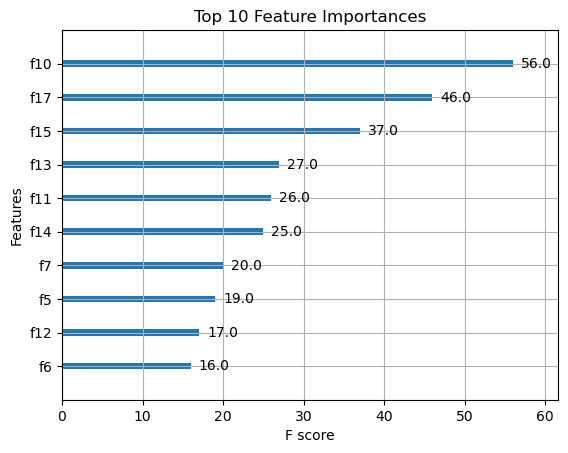

In [81]:
import matplotlib.pyplot as plt

xgb.plot_importance(booster, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

In [ ]:
### Print confusion matrix

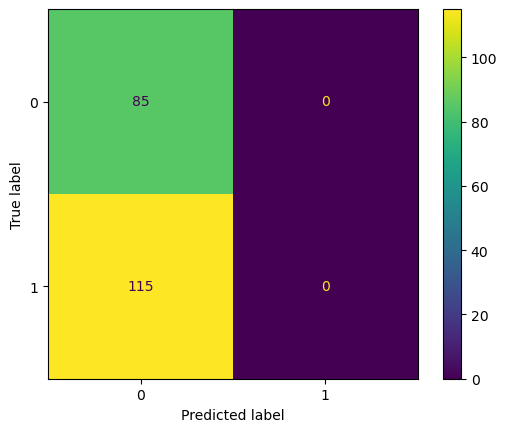

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Summary note
We will focus more on model deployment and generate matrices

### Alarm monitoring from cloud watch

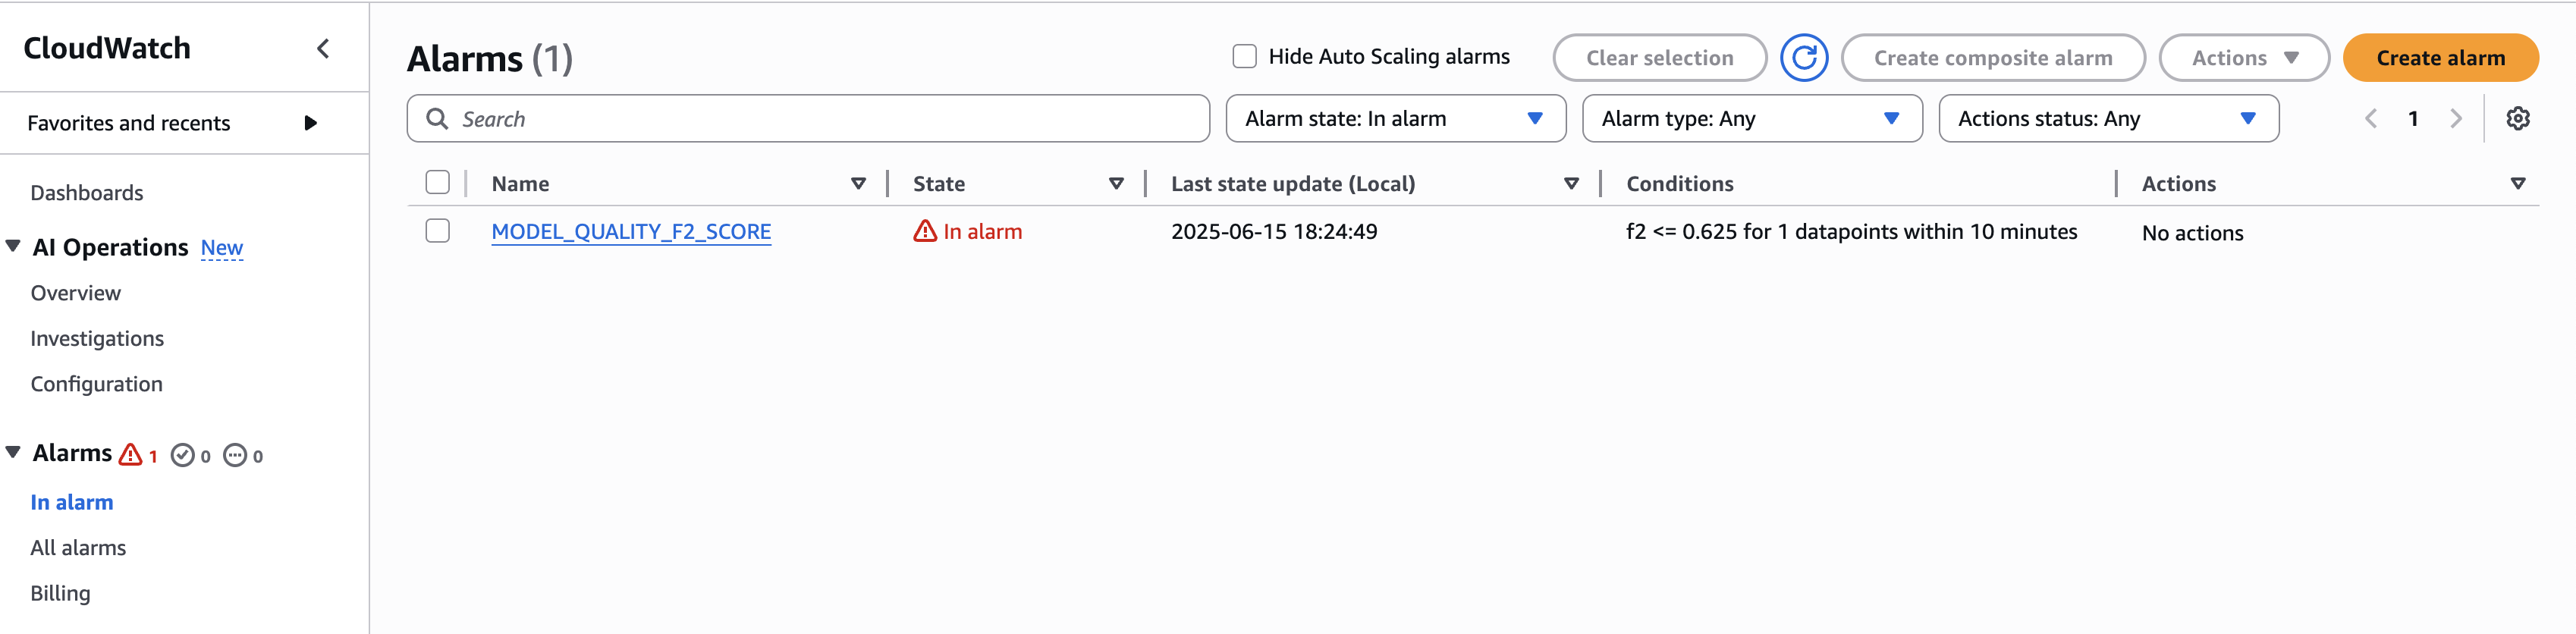

## Create a Model store from the previously created RandomForestClassifier model

In [ ]:
import joblib
import os
import tarfile
import boto3
import sagemaker
from sagemaker import get_execution_role


# --- SageMaker + S3 Setup ---
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = get_execution_role()
prefix = "autism-model-store"
model_dir = "model"
os.makedirs(model_dir, exist_ok=True)

# --- Save model locally ---
model_file = os.path.join(model_dir, "model.joblib")
joblib.dump(clf, model_file)

# --- Package as model.tar.gz (SageMaker expects this format) ---
tar_file = os.path.join(model_dir, "model.tar.gz")
with tarfile.open(tar_file, mode="w:gz") as tar:
    tar.add(model_file, arcname="model.joblib")

# --- Upload to S3 ---
model_artifact_s3_uri = sagemaker_session.upload_data(tar_file, bucket=bucket, key_prefix=prefix)
print(f" Uploaded model.tar.gz to S3: {model_artifact_s3_uri}")


### Register model to SageMaker Model store

In [ ]:
# --- Create Model Package Group (if not exists) ---
client = boto3.client("sagemaker", region_name=region)
model_package_group_name = "AutismClassifierPackageGroupV2"

try:
    client.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription="RandomForestClassifier for ASD detection"
    )
    print(f"Created Model Package Group: {model_package_group_name}")
except client.exceptions.ResourceInUse:
    print(f"Model Package Group '{model_package_group_name}' already exists.")

# --- Register the model ---
model_package_response = client.create_model_package(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageDescription="ASD prediction model using RandomForestClassifier",
    InferenceSpecification={
        "Containers": [
            {
                "Image": sagemaker.image_uris.retrieve(
                    framework="sklearn", region=region, version="1.0-1"
                ),
                "ModelDataUrl": model_artifact_s3_uri,
            }
        ],
        "SupportedContentTypes": ["text/csv"],
        "SupportedResponseMIMETypes": ["text/csv"]
    },
    ModelApprovalStatus="PendingManualApproval"
)

print(f"Model registered to Model Package Group '{model_package_group_name}'")


## Create a model endpoint

### Set the Model status to Approved

In [ ]:
response = sm_client.list_model_packages(
    ModelPackageGroupName="AutismClassifierPackageGroupV1",
    SortBy="CreationTime",
    SortOrder="Descending",
    MaxResults=1
)

model_package_arn = response["ModelPackageSummaryList"][0]["ModelPackageArn"]
print(f"Latest Model Package ARN: {model_package_arn}")


In [ ]:
sm_client.update_model_package(
    ModelPackageArn=model_package_arn,
    ModelApprovalStatus="Approved",
    ApprovalDescription="Manually approved for endpoint deployment"
)

print(f"Model Package approved: {model_package_arn}")

### Create an model deployment

In [ ]:
import boto3
import time
import sagemaker
from sagemaker import get_execution_role

# --- Config ---
region = boto3.Session().region_name
sm_client = boto3.client("sagemaker", region_name=region)
sagemaker_session = sagemaker.Session()
role = get_execution_role()

# --- Use the latest approved model package ARN from the registry ---

# Get the latest approved model package
response = sm_client.list_model_packages(
    ModelPackageGroupName="AutismClassifierPackageGroupV1",
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    SortOrder="Descending",
    MaxResults=1
)


if not response["ModelPackageSummaryList"]:
    raise ValueError("No approved model found. Approve one in SageMaker Model Registry first.")

model_package_arn = response["ModelPackageSummaryList"][0]["ModelPackageArn"]
print(f"Using Model Package ARN: {model_package_arn}")


In [ ]:
# --- Unique names for endpoint and config ---
endpoint_name = f"asd-classifier-endpoint-{int(time.time())}"
model_name = f"asd-classifier-model-{int(time.time())}"
endpoint_config_name = f"{endpoint_name}-config"

# --- Create Model from Model Package ---
sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "ModelPackageName": model_package_arn
    }
)
print(f"Created model: {model_name}")

# --- Create Endpoint Configuration ---
sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name,
            "InitialInstanceCount": 1,
            "InstanceType": "ml.m5.large",
            "InitialVariantWeight": 1
        }
    ]
)
print(f"Created endpoint config: {endpoint_config_name}")

# --- Deploy the Endpoint ---
sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)
print(f"Creating endpoint: {endpoint_name} (this may take a few minutes...)")


### Wait for the endpoint creation to complete

In [ ]:
import time

def wait_for_endpoint(endpoint_name):
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    while status not in ["InService", "Failed"]:
        print(f"Endpoint status: {status}. Waiting...")
        time.sleep(15)
        status = sm_client.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status == "InService":
        print(f"Endpoint '{endpoint_name}' is InService and ready!")
    else:
        raise RuntimeError(f"Endpoint creation failed with status: {status}")

wait_for_endpoint(endpoint_name)

### Model deployment failure troubleshooting
The model deployment failed, so running few steps to make it succeeded

In [ ]:
import joblib
import os
import pandas as pd
from sagemaker.sklearn.model import SKLearnModel

def model_fn(model_dir):
    model_path = os.path.join(model_dir, "model.joblib")
    return joblib.load(model_path)

def input_fn(request_body, request_content_type):
    if request_content_type == "text/csv":
        return pd.read_csv(pd.compat.StringIO(request_body), header=None)
    raise ValueError("Unsupported content type: {}".format(request_content_type))

def predict_fn(input_data, model):
    return model.predict(input_data)

def output_fn(prediction, content_type):
    if content_type == "text/csv":
        return ",".join(str(x) for x in prediction)
    raise ValueError("Unsupported content type: {}".format(content_type))

## Model deployment using XGBoost model

In [83]:
import sagemaker
from sagemaker import image_uris, Model

# --- Setup ---
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

# --- XGBoost image URI ---
xgb_image_uri = image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.7-1"
)

# --- Model artifact path ---
model_artifact = "s3://sagemaker-us-east-1-553246940090/autism_prediction/csv/output/xgb-tuner-2025-06-22-19-09-45/sagemaker-xgboost-250622-1909-001-8be10e5e/output/model.tar.gz"

# --- Define model ---
xgb_model = Model(
    image_uri=xgb_image_uri,
    model_data=model_artifact,
    role=role,
    sagemaker_session=sess
)

# --- Deploy to endpoint ---
endpoint_name = "xgb-autism-predictor"
predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name
)

print(f"\nModel deployed to endpoint: {endpoint_name}")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-06-22-19-38-26-707
INFO:sagemaker:Creating endpoint-config with name xgb-autism-predictor
INFO:sagemaker:Creating endpoint with name xgb-autism-predictor


------!
Model deployed to endpoint: xgb-autism-predictor


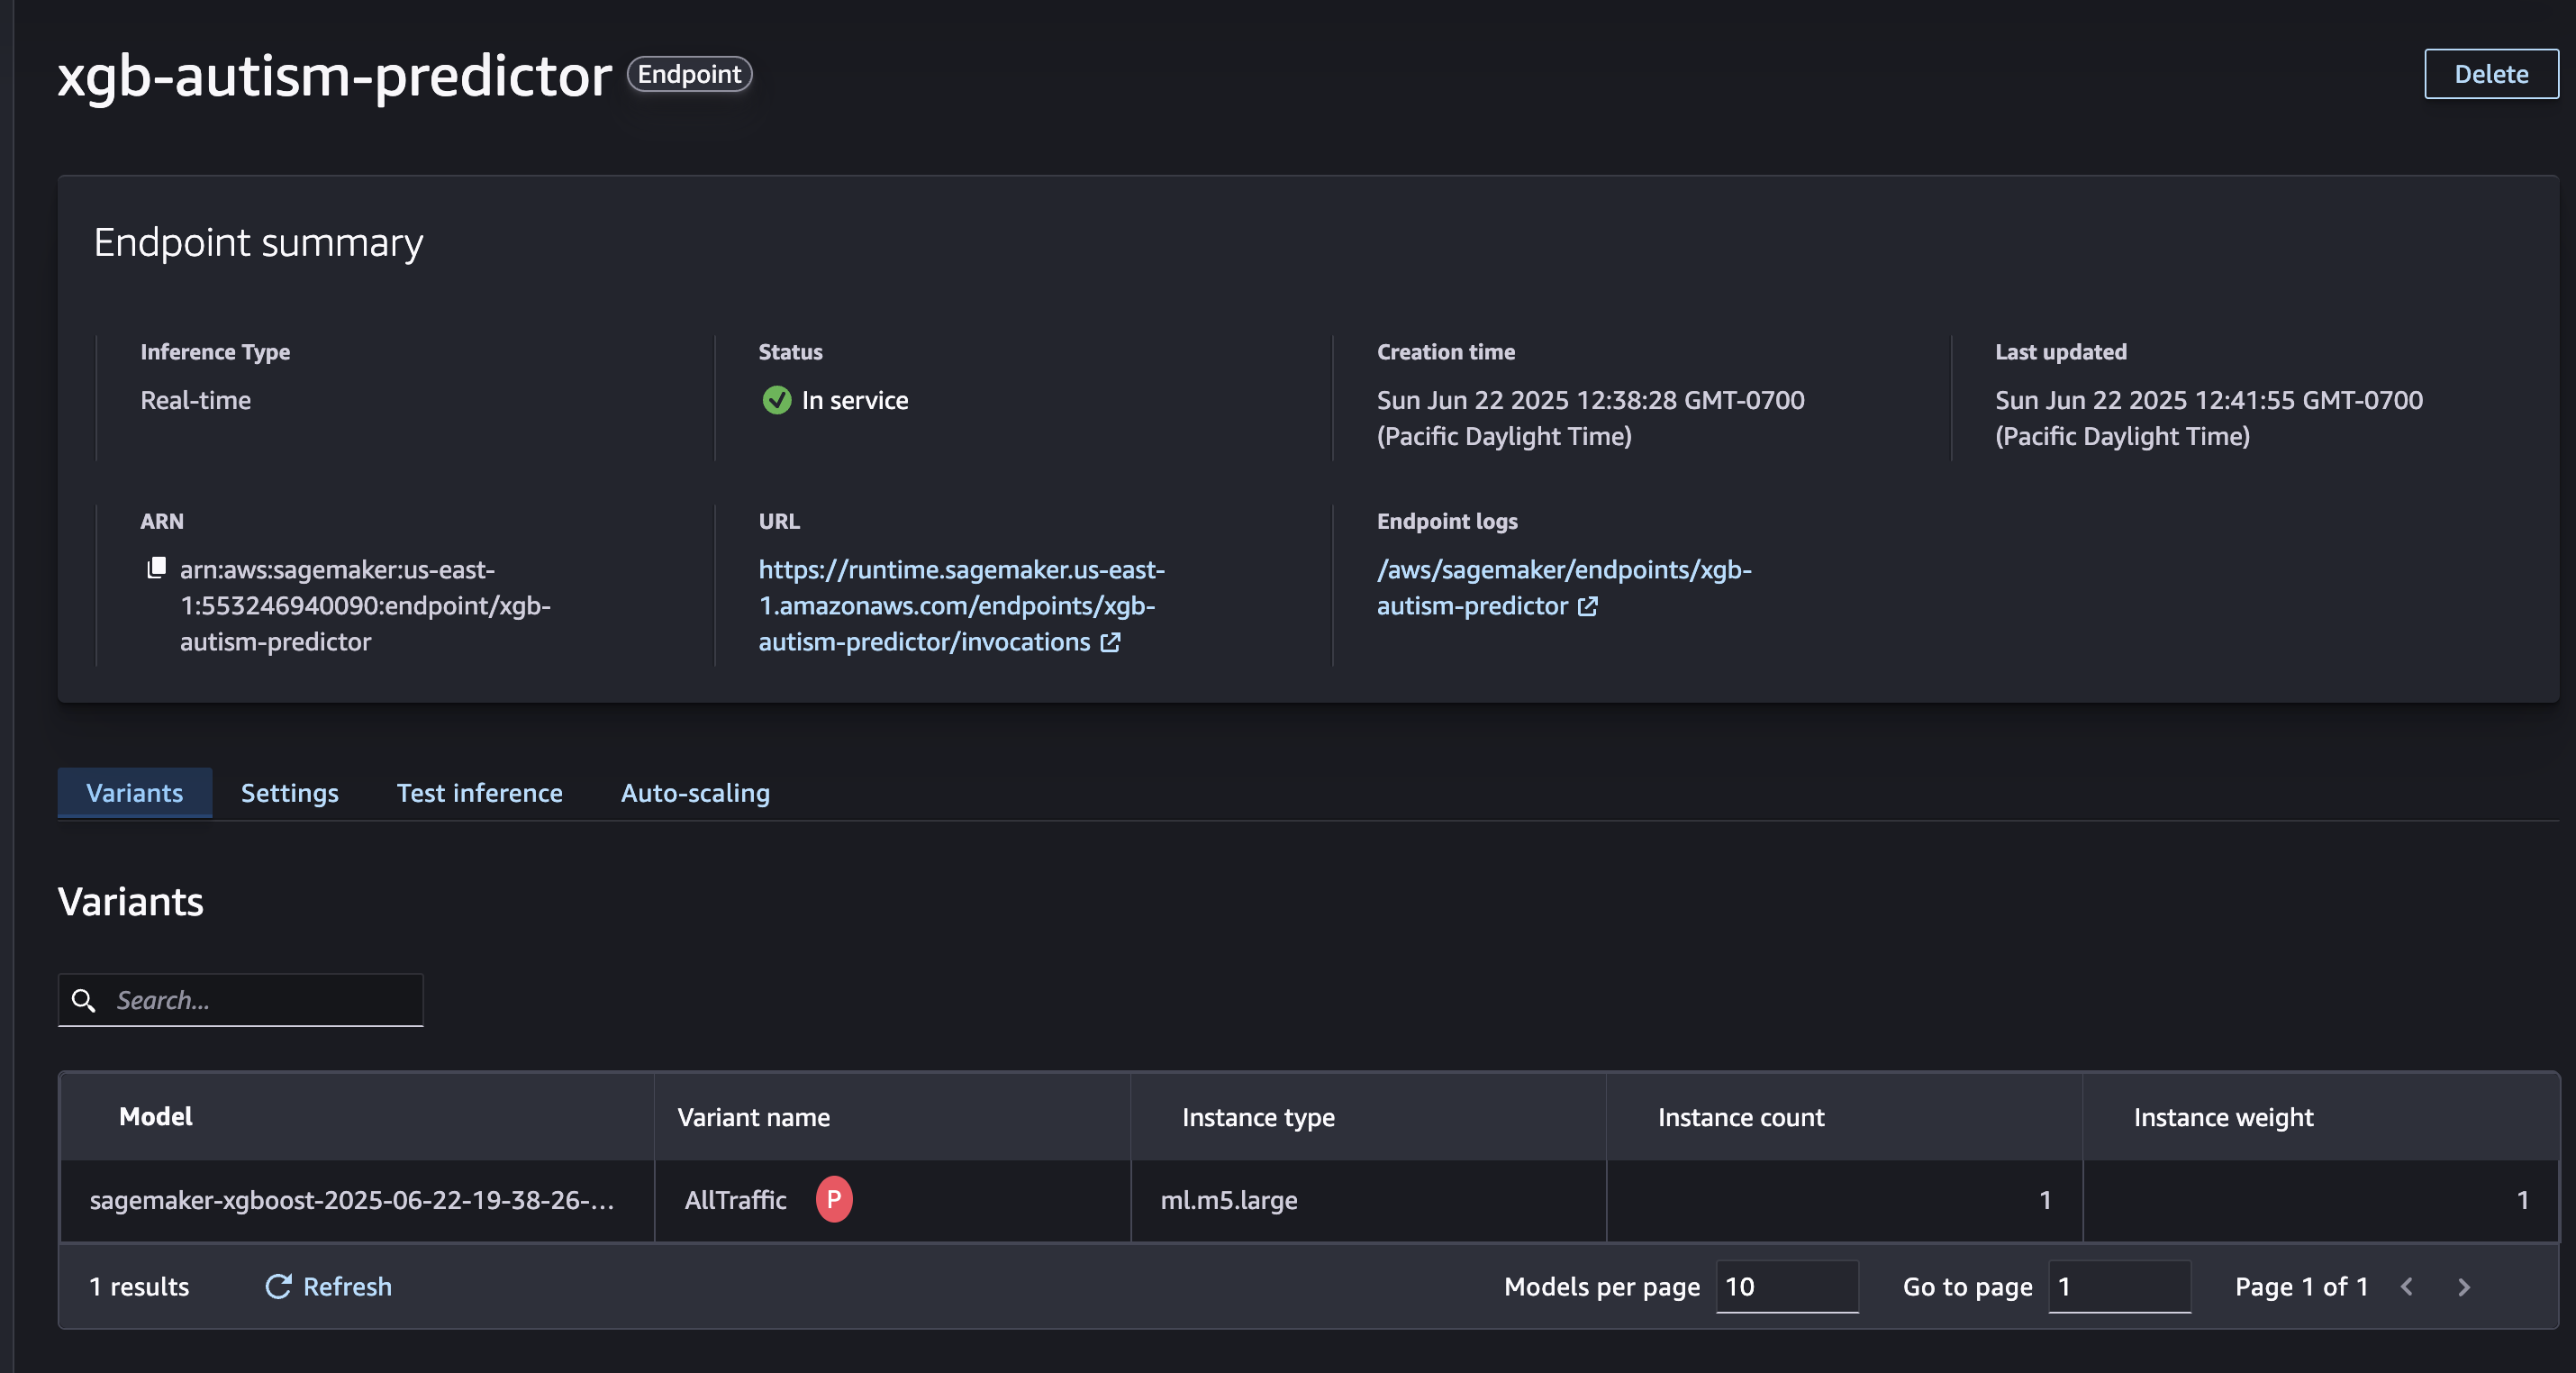

#### Predict using some test data

In [88]:
import numpy as np
import pandas as pd
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer

# Load test data
df_val = pd.read_csv("test_xgb_clean.csv", header=None)
X_val = df_val.iloc[:, 1:].values
y_true = df_val.iloc[:, 0].values

# Pick a random row
rand_index = np.random.randint(0, len(X_val))
sample = X_val[rand_index]
actual_label = y_true[rand_index]

# Setup predictor with correct CSV serializer
predictor = Predictor(
    endpoint_name="xgb-autism-predictor",
    serializer=CSVSerializer()
)

# Send prediction
response = predictor.predict(sample)

# Convert response to float
pred_prob = float(response)
pred_label = int(pred_prob > 0.5)

# Display result
print(f"Random Sample Index: {rand_index}")
print(f"Predicted Probability: {pred_prob:.4f}")
print(f"Predicted Label: {pred_label}")
print(f"Actual Label   : {actual_label}")


Random Sample Index: 39
Predicted Probability: 0.0577
Predicted Label: 0
Actual Label   : 0


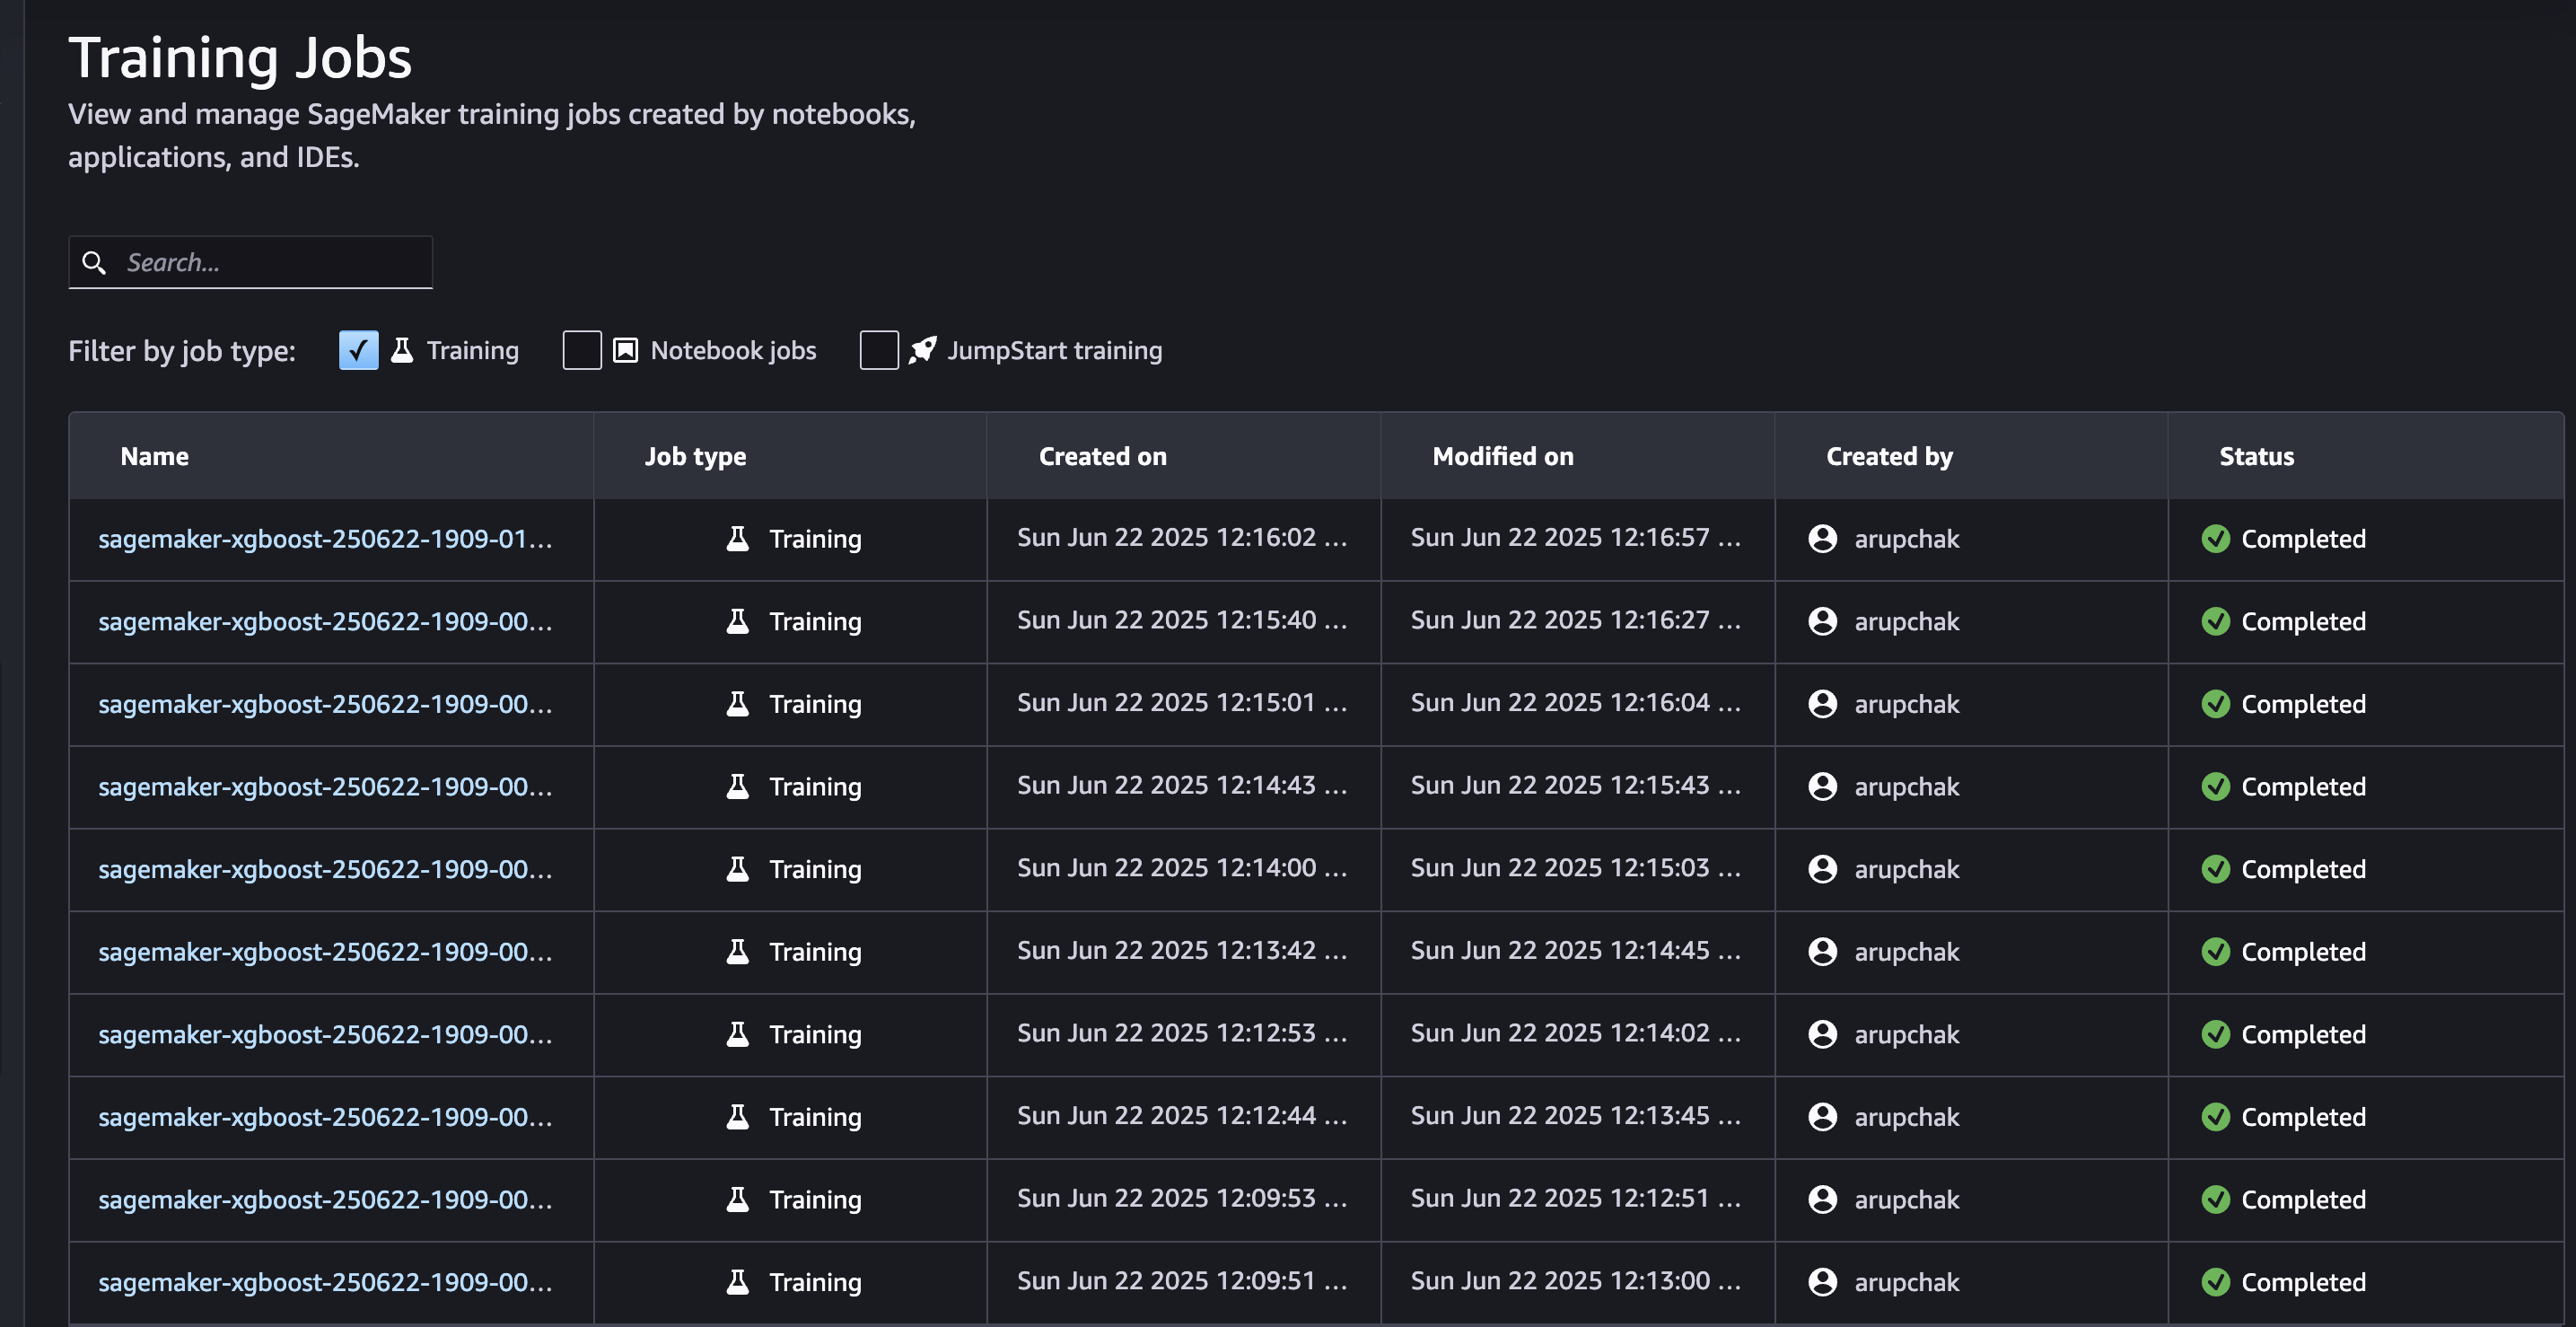

## Monitoring setup

To perform the monitoring setup, we will follow the below steps:
* Setup Baseline Job using training data
* Create a monitoring schedule
* View Monitoring Reports
* View Monitoring Status

In [89]:
from sagemaker.model_monitor import DefaultModelMonitor

monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=sess
)

baseline_job_name = "xgb-baseline-job"
baseline_prefix = "autism_monitoring/baseline"
baseline_output_uri = f"s3://{bucket}/{baseline_prefix}/output"

# Input: SMOTE-balanced training data
baseline_dataset_uri = f"s3://{bucket}/autism_prediction/csv/train/train_xgb_balanced.csv"

monitor.suggest_baseline(
    baseline_dataset=baseline_dataset_uri,
    dataset_format={"csv": {"header": False}},
    output_s3_uri=baseline_output_uri,
    wait=True,
    job_name=baseline_job_name
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating processing-job with name xgb-baseline-job


...............2025-06-22 19:53:07.682869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-22 19:53:07.682933: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-22 19:53:09.361758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-06-22 19:53:09.361791: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-06-22 19:53:09.361813: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-217-131.ec2.internal): /proc/driver/nvidia/version does not exist
2025-06-22 19:53:09.362237: I ten

In [102]:
import time
import boto3

sm_client = boto3.client("sagemaker")

def wait_for_endpoint(endpoint_name, timeout_sec=180):
    for _ in range(timeout_sec // 5):
        try:
            resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
            if resp["EndpointStatus"] == "InService":
                print(f"Endpoint '{endpoint_name}' is ready.")
                return
        except sm_client.exceptions.ClientError:
            pass
        time.sleep(5)
    raise TimeoutError(f"Endpoint '{endpoint_name}' did not become available in time.")

# Wait before invoking monitoring setup
wait_for_endpoint("xgb-autism-predictor")


Endpoint 'xgb-autism-predictor' is ready.


In [106]:
# View Monitoring status

# List generated reports
report_prefix = f"autism_monitoring/reports/{monitoring_schedule_name}"
print(f" S3 path to reports: s3://{bucket}/{report_prefix}/")

 S3 path to reports: s3://sagemaker-us-east-1-553246940090/autism_monitoring/reports/xgb-autism-monitor-schedule/


In [110]:
import boto3

# Initialize Boto3 SageMaker client
sm_client = boto3.client("sagemaker")

# Replace with your actual monitoring schedule name
monitoring_schedule_name = "DEMO-xgb-churn-monitoring-schedule-2025-06-20-2015-v1"

# Get monitoring schedule status
response = sm_client.describe_monitoring_schedule(
    MonitoringScheduleName=monitoring_schedule_name
)

status = response["MonitoringScheduleStatus"]
print("Monitoring Schedule Status:", status)

Monitoring Schedule Status: Scheduled


In [109]:
schedules = sm_client.list_monitoring_schedules()["MonitoringScheduleSummaries"]

for schedule in schedules:
    print(f"Name: {schedule['MonitoringScheduleName']} | Status: {schedule['MonitoringScheduleStatus']}")

Name: DEMO-xgb-churn-monitoring-schedule-2025-06-20-2015-v1 | Status: Scheduled


## Model Registry

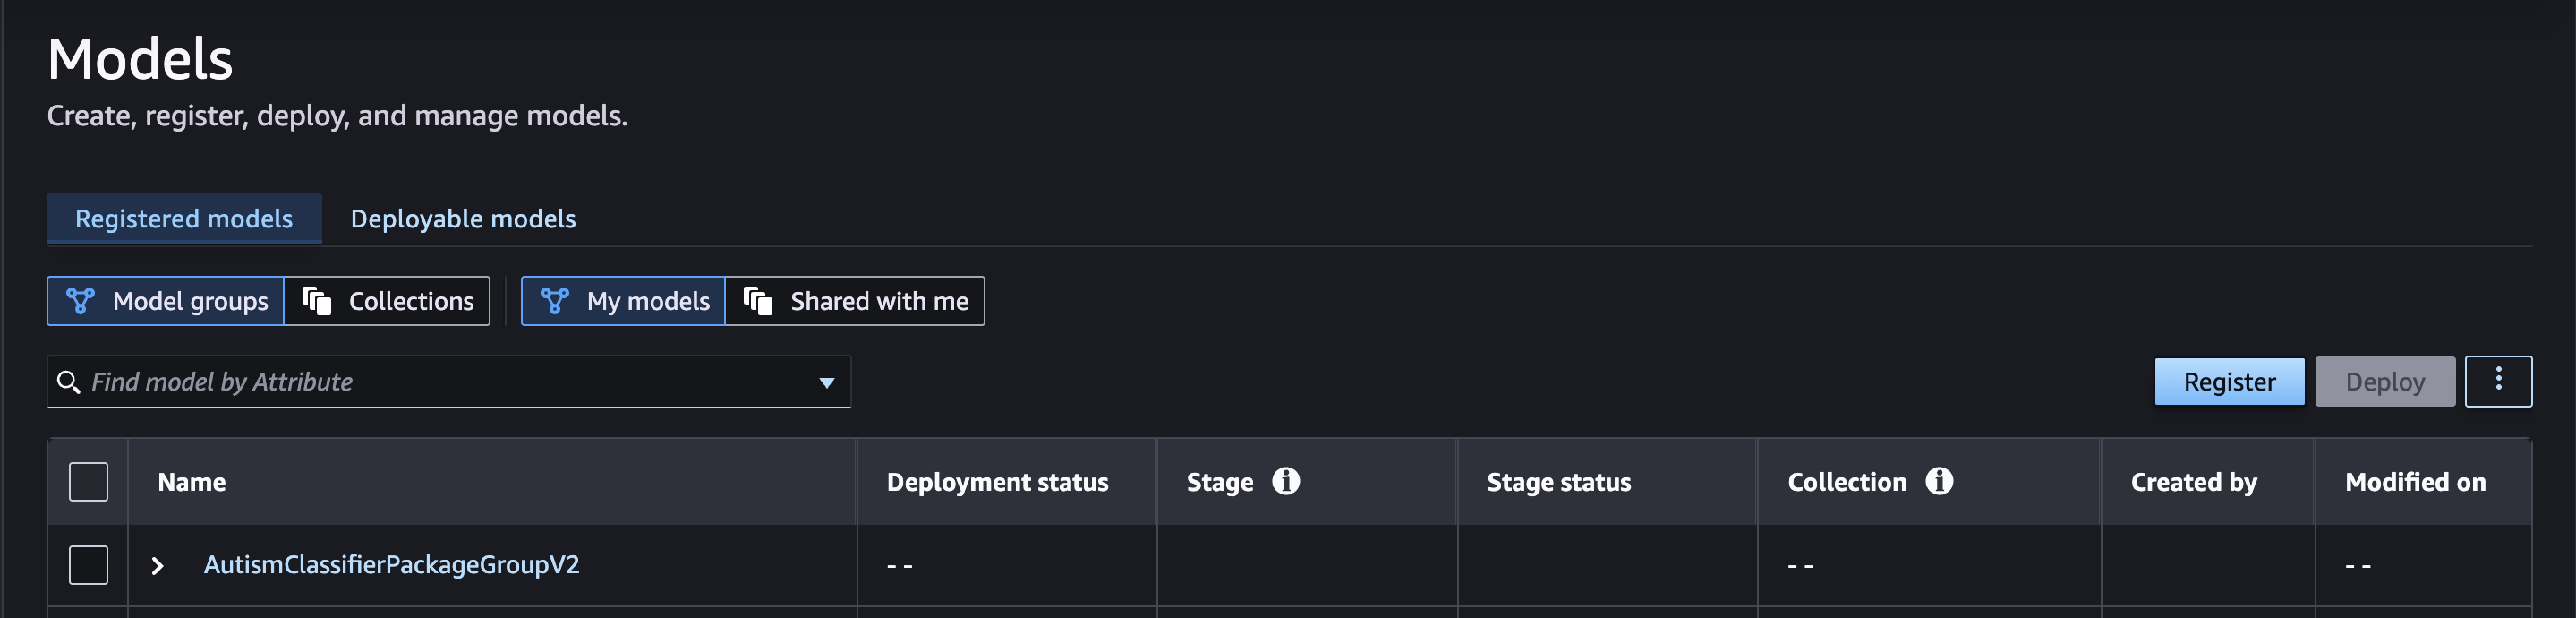

## Model drift and feature drift

To monitor the model performance, we need to monitor the model drift and feature drift over time

In [111]:
import pandas as pd
from datetime import datetime
from IPython.display import display
import boto3

# Load constraint and statistics report (latest)
bucket = "sagemaker-us-east-1-553246940090"
prefix = "autism_prediction/reports/output"
s3_path = f"s3://{bucket}/{prefix}"

# We'll use Boto3 to list the files in the output report path
s3 = boto3.client("s3")

# List objects in the monitoring output directory
result = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
report_files = [content['Key'] for content in result.get('Contents', []) if content['Key'].endswith("constraints.json") or content['Key'].endswith("statistics.json")]

report_files

[]

In [ ]:
import boto3

sm_client = boto3.client("sagemaker")
schedule_name = "DEMO-xgb-churn-monitoring-schedule-2025-06-20-2015-v1"

response = sm_client.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)
print("Status:", response["MonitoringScheduleStatus"])
print("Last Modified:", response["LastModifiedTime"])


In [ ]:
response = sm_client.list_monitoring_executions(MonitoringScheduleName=schedule_name)
executions = response["MonitoringExecutionSummaries"]

if executions:
    for job in executions:
        print(f"Status: {job['MonitoringExecutionStatus']}")
        print(f"Start: {job['CreationTime']} | End: {job.get('EndTime', 'N/A')}")
else:
    print("No executions found. We need to wait for the job execution to complete.")

| Check Type     | Source File                              | What It Analyzes                            |
| -------------- | ---------------------------------------- | ------------------------------------------- |
| Accuracy Drift | `constraints.json`                       | Constraint violations (e.g., accuracy drop) |
| Feature Drift  | `statistics.json`                        | Drift on individual input features          |
| Model Drift    | Inferred via drift or violation patterns |                                             |


In [117]:
import boto3

bucket = "sagemaker-us-east-1-553246940090"
prefix = "autism_monitoring/reports/xgb-autism-monitor-schedule/"

s3 = boto3.client("s3")

response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

print("Files found in S3 path:")
for obj in response.get("Contents", []):
    print(" -", obj["Key"])

Files found in S3 path:


In [ ]:
import boto3
import json
import pandas as pd
from urllib.parse import urlparse

bucket = "sagemaker-us-east-1-553246940090"
report_prefix = "autism_monitoring/reports/xgb-autism-monitor-schedule/"

s3 = boto3.client("s3")

# --- Step 1: Get latest constraints.json file ---
def get_latest_constraints_report(bucket, prefix):
    result = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    reports = [obj['Key'] for obj in result.get('Contents', []) if obj['Key'].endswith("constraints.json")]
    
    if not reports:
        raise ValueError("No constraints.json report found.")
    
    latest = sorted(reports)[-1]
    return f"s3://{bucket}/{latest}"

report_s3_path = get_latest_constraints_report(bucket, report_prefix)

# --- Step 2: Download constraints.json file ---
def download_s3_file(s3_uri):
    parsed = urlparse(s3_uri)
    bucket = parsed.netloc
    key = parsed.path.lstrip('/')
    local_path = "/tmp/constraints.json"
    s3.download_file(bucket, key, local_path)
    return local_path

local_path = download_s3_file(report_s3_path)

# --- Step 3: Load and parse violations ---
with open(local_path) as f:
    constraints = json.load(f)

violations = constraints.get("violations", [])

# --- Step 4: Display violations ---
if violations:
    df_drift = pd.DataFrame(violations)
    print("Drift Detected:")
    display(df_drift[["feature_name", "constraint_check_type", "description"]])
else:
    print("No feature or model drift detected.")

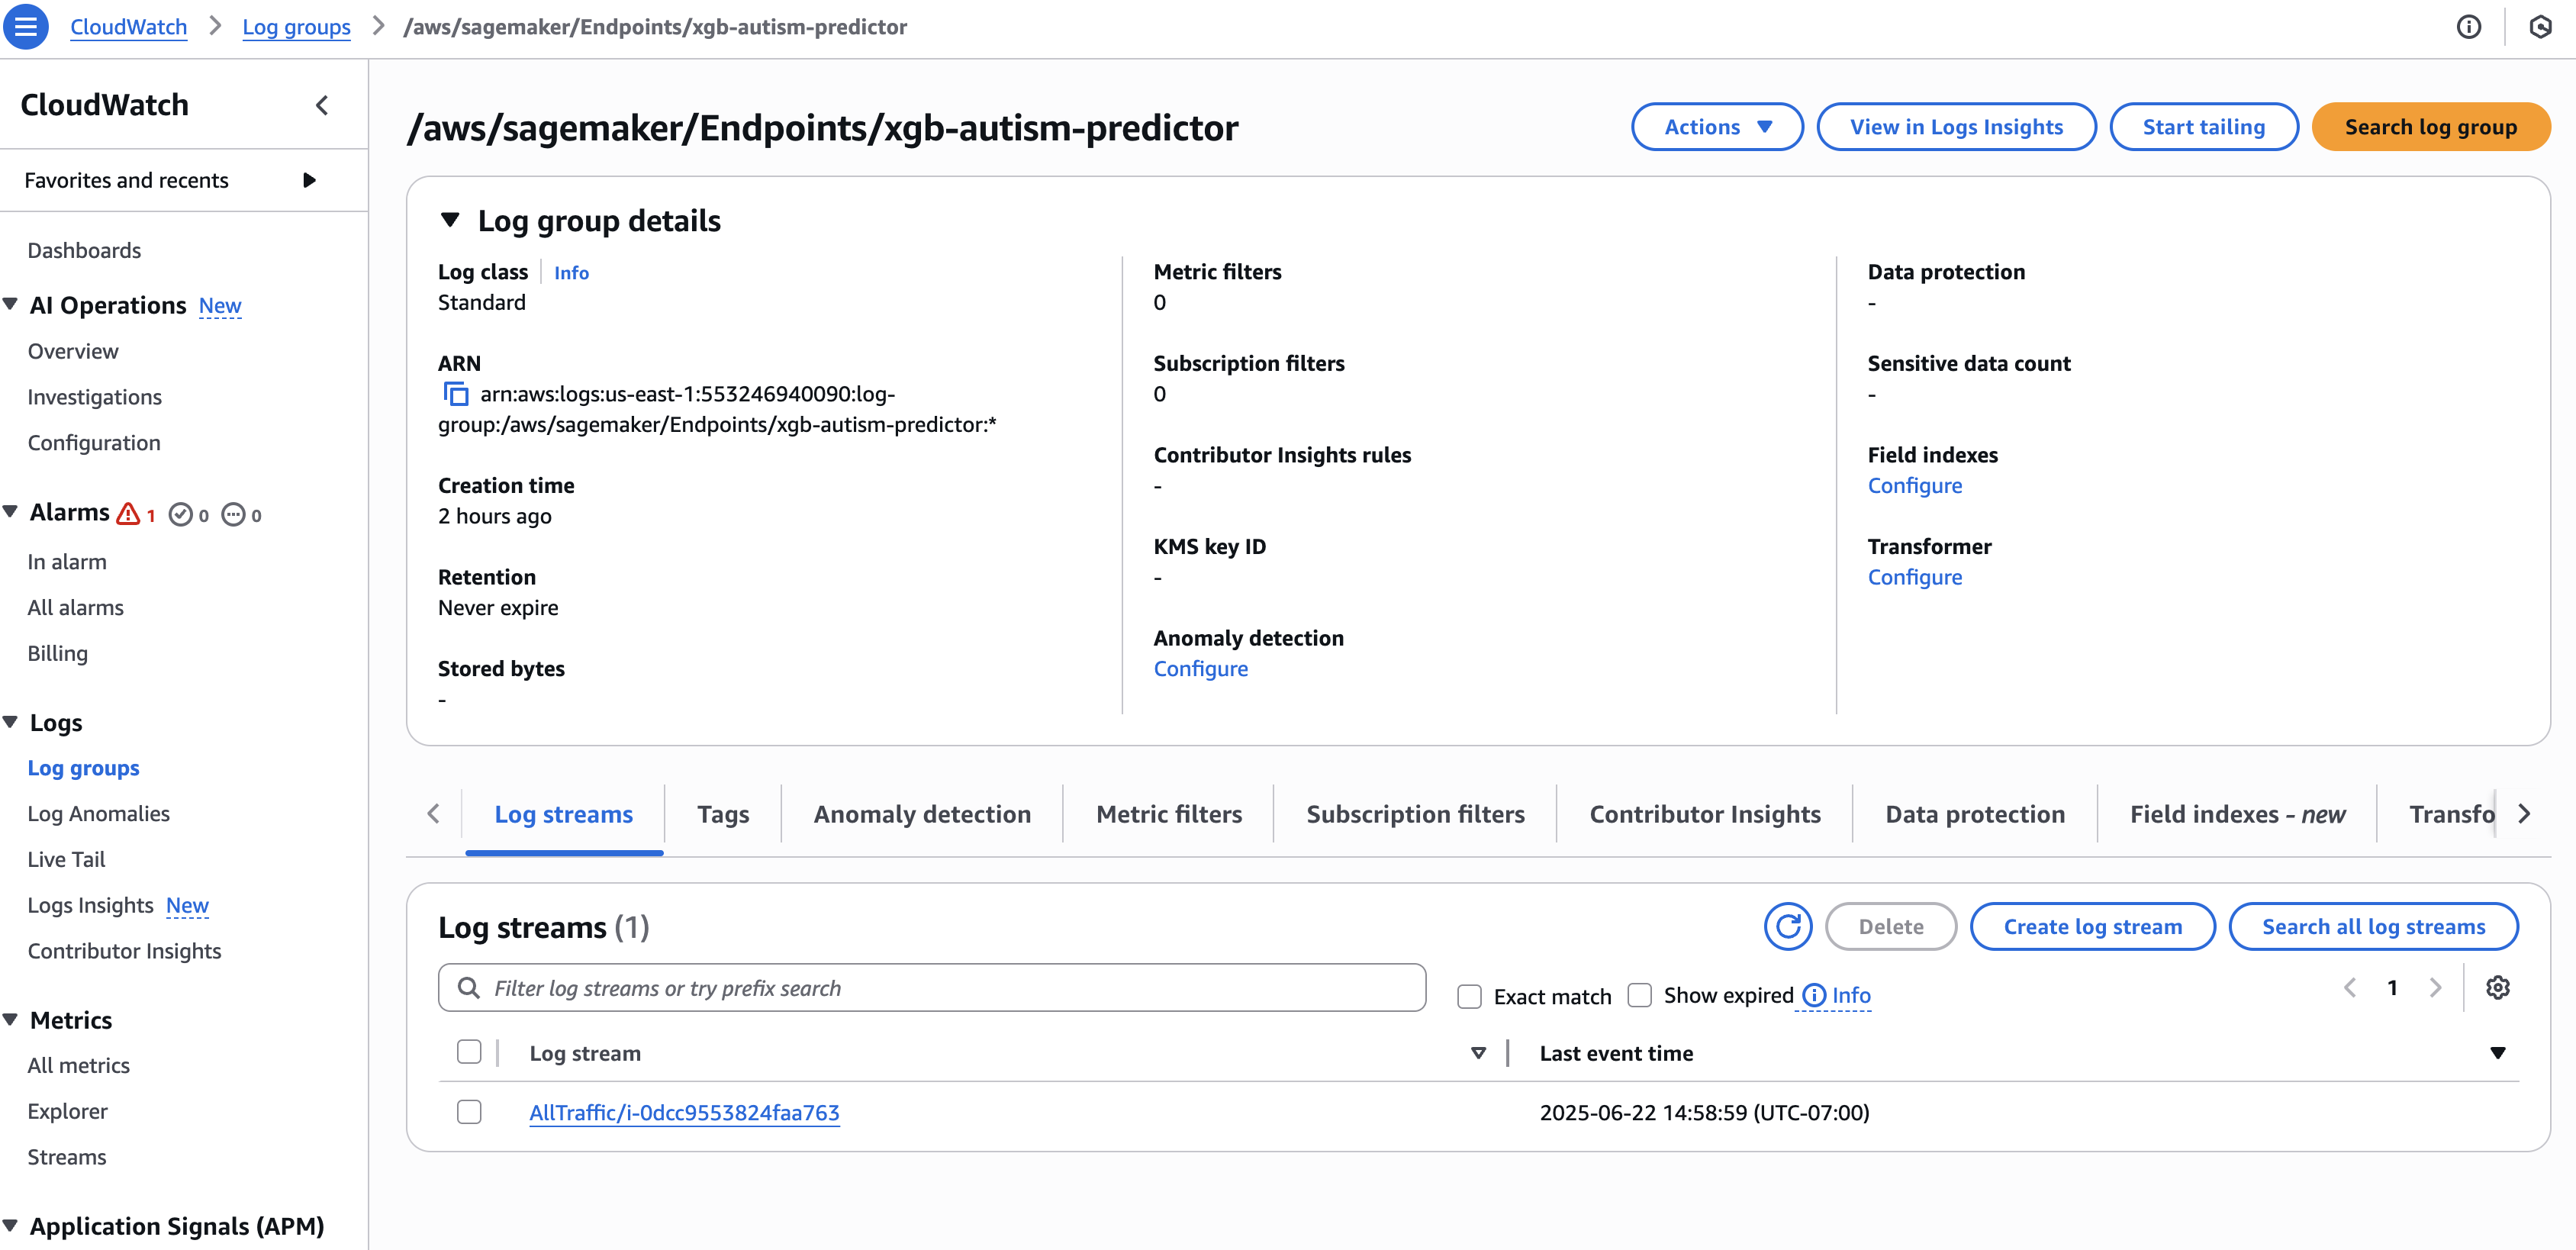